# CZ1016 Movie Recommendation System

Dear all, welcome to our group's project. In this project, we will take you through the process of how we came up with the project followed by a short demonstration of how it works.
<a class="anchor" id="0.0"></a>
### Content Page

##### Introduction
   * 1.1  [Importing Relevant Packages](#1.1)
   * 1.2  [Data Handling](#1.2)
       * 1.2.1  [INSERT NEW DATASET](#1.2.1)

##### Exploratory Data Analysis
   * 2.1  [Cleaning and Exploring](#2.1)
       * 2.1.1  [Filtering out the movie you possibly don't know](#2.1.1)
       * 2.1.2  [Nobody likes a short movie](#2.1.2)
   
   
   * 2.2  [Exploring the Dataset](#2.2)
       * 2.2.1  [Who directed the most?](#2.2.1)
       * 2.2.2  [Top 10 Most Popular Movies](#2.2.2)
       * 2.2.3  [What's the most seen genres?](#2.2.3)
       * 2.2.4  [What are the languages most used in movies?](#2.2.4)
       * 2.2.5  [Year and Ratings distributions](#2.2.5)
       * 2.2.6  [Again, runtime of the movies](#2.2.6)
       * 2.2.7  [Which country produced most movies?](#2.2.7)
     
     
   * 2.3  [Relations between variables](#2.3)
       
##### Movie Recommender 1
   * 3.1  [Movie Recommender 1](#3.1)
       * 3.1.1  [Rate some movies](#3.1.1)
       * 3.1.2  [Handling movie bias - Imputation of Values](#3.1.2)
       * 3.1.3  [Truncated Singular Vector Decomposition](#3.1.3)
           * 3.1.3.1  [Visual Plot](#3.1.3.1)
           * 3.1.3.2  [First Recommendation](#3.1.3.2)
       * 3.1.4  [Alternating Least Square Method](#3.1.4)
       
##### More Movies Sources
   * 4.1  [Extra movie datasets](#4.1)
       * 4.1.1  [Golden Village Dataset](#4.1.1)
       
##### Application on our Business Case
   * 5.1  [Golden Village Movie Recommender](#5.1)
       * 5.1.1  [Recommendation by implementing TF-IDF and cosine similarity](#5.1.1)
       * 5.1.2  [Our Own Function - Recommendation based on Average Weighted Similarity](#5.1.2)
       * 5.1.3  [Find you the Nearest Cinema! Grab your ticket and popcorn!](#5.1.3)
   * 5.2 [One line codes](#5.2)
       * 5.2.1  [Recommend by implementing TF-IDF and cosine similarity](#5.2.1)
       * 5.2.2  [Recommend based on our defined function](#5.2.2)
       * 5.2.3  [Find nearest cinema and timings](#5.2.3)

<a class="anchor" id="1.1"></a>
### Importing the relevant packages

In [2]:
# We will first import our basic modules and packages
import ast
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from pandas.core.common import SettingWithCopyWarning
from pandas.core.common import SettingWithCopyWarning
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', message="^Columns.*")

#pip install plotly pip install cufflinks
# OR
#conda install -c conda-forge cufflinks-py

# Plotly
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

<a class="anchor" id="1.2"></a>
### Data Handling

In this segment, our group will perform importing of the relevant datasets using `pd.read_csv()` function and storing them into the variables `movies`, `link`, `keywords`, `metadata` and `credit`. The dataset we have chosen is the <b>IMDB Dataset</b>

* `movies`: Different ratings of movies by the different users
* `link`: Linking ImdbID and MovieID
* `keyword`: Keywords within the movies 
* `metadata`: Dataset containing the information about the individual movies (eg. Title, Actor, Overview ...)
* `credit`: Contains the cast in the credit scenes

In [3]:
movies = pd.read_csv('ratings_small.csv').drop(columns = ['timestamp'])
link = pd.read_csv('links_small.csv').drop(columns= ['tmdbId'])
keywords = pd.read_csv('keywords.csv')
metadata = pd.read_csv('movies_metadata.csv').drop(columns=['vote_count', 'vote_average','video','tagline','status'])
credit = pd.read_csv('credits.csv')

print("Movies dataset is", movies.shape)
print("Links dataset is", link.shape)
print("Keywords dataset is", keywords.shape)
print("Metadata dataset is", metadata.shape)
print("Credits dataset is", credit.shape)

Movies dataset is (100004, 3)
Links dataset is (9125, 2)
Keywords dataset is (46419, 2)
Metadata dataset is (45466, 19)
Credits dataset is (45476, 3)


In [4]:
data = pd.merge(movies, link, on='movieId')
data.head()

userId  movieId  rating  imdbId
0       1       31     2.5  112792
1       7       31     3.0  112792
2      31       31     4.0  112792
3      32       31     4.0  112792
4      36       31     3.0  112792

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
 3   imdbId   100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.8 MB


In [6]:
metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
title                     object
dtype: object

In [7]:
metadata['imdb_id'] = metadata['imdb_id'].str[2:]

# Converting metadata IMDB ID column into an Integer
metadata_imdb = pd.DataFrame(metadata['imdb_id'].dropna()).replace('',0).astype(np.int64)

# Rename Meta Data IMDB ID to imdbid
metadata = metadata[metadata.imdb_id.notnull()]
metadata['imdb_id'] = metadata_imdb
metadata = metadata.rename(columns={"imdb_id": "imdbId"})
print(metadata.shape)
metadata.head(3)

(45449, 19)


adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   

                               homepage     id  imdbId original_language  \
0  http://toystory.disney.com/toy-story    862  114709                en   
1                                   NaN   8844  113497                en   
2                                   NaN  15602  113228                en   

     original_title                                           overview  \
0         Toy Story  Led by Woody, Andy's toys live happily in his ...   
1           Jumanji  When siblings Judy and Peter discover an encha...   
2  Grumpier Old Men  A family wedding reignites the ancient feud be...   

  popularity                       poster_path  \
0  21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1  17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2  11.712900  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   

                                production_companies  \
0     [{'name': 'Pixar Animation Studios', 'id': 3}]   
1  [{'name': 'TriStar Pictures', 'id': 559}, {'na...   
2  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   

                                production_countries release_date  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-10-30   
1  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-15   
2  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-22   

       revenue  runtime                                   spoken_languages  \
0  373554033.0     81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0    104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0    101.0           [{'iso_639_1': 'en', 'name': 'English'}]   

              title  
0         Toy Story  
1           Jumanji  
2  Grumpier Old Men

### Constructing the average rating for the dataset

As we have both the datasets containing movie details and ratings from different user, we will construct the **Average Rating** for each movie by calculating the average of users' rating.

In [8]:
# Let's see the user rating for each movies tgt with their title
data = pd.merge(data, metadata[['title','imdbId']], on = 'imdbId')
data

userId  movieId  rating  imdbId                          title
0           1       31     2.5  112792                Dangerous Minds
1           7       31     3.0  112792                Dangerous Minds
2          31       31     4.0  112792                Dangerous Minds
3          32       31     4.0  112792                Dangerous Minds
4          36       31     3.0  112792                Dangerous Minds
...       ...      ...     ...     ...                            ...
99801     664    64997     2.5  449040  H.G. Wells' War of the Worlds
99802     664    72380     3.5  362478                        The Box
99803     665      129     3.0  114131                 Pie in the Sky
99804     665     4736     1.0  234829                   Summer Catch
99805     668     6425     1.0  120142                  The Sixth Man

[99806 rows x 5 columns]

In [9]:
# Here, we get the average rating for each movies based on the user rating
meandata = pd.DataFrame(data.groupby('title')['rating'].mean().sort_values(ascending = False))
meandata = meandata.rename(columns = {'rating':'Average_rating'})
print(meandata.shape)
meandata.head()

(8740, 1)


Average_rating
title                                                      
The House Bunny                                         5.0
Message to Love: The Isle of Wight Festival             5.0
Me Before You                                           5.0
The Day the Sun Turned Cold                             5.0
Mei and the Kittenbus                                   5.0

In [10]:
# Let us merge the metadata with the meandata (containing the found average ratings for each movie) we just created
merged_data = pd.merge(metadata,meandata, on='title').drop(columns=['adult','budget','homepage','original_language','original_title','revenue','poster_path'])
merged_data['id'] = merged_data['id'].astype(np.int64)

# Let us merge the already merged data with the credits dataset
merged_data = pd.merge(merged_data, credit, on = 'id')
print("Final Dataset Size", merged_data.shape)
olddate=merged_data
merged_data.head()

Final Dataset Size (10295, 15)


belongs_to_collection  \
0  {'id': 10194, 'name': 'Toy Story Collection', ...   
1                                                NaN   
2  {'id': 119050, 'name': 'Grumpy Old Men Collect...   
3                                                NaN   
4  {'id': 96871, 'name': 'Father of the Bride Col...   

                                              genres     id  imdbId  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862  114709   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844  113497   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602  113228   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357  114885   
4                     [{'id': 35, 'name': 'Comedy'}]  11862  113041   

                                            overview popularity  \
0  Led by Woody, Andy's toys live happily in his ...  21.946943   
1  When siblings Judy and Peter discover an encha...  17.015539   
2  A family wedding reignites the ancient feud be...  11.712900   
3  Cheated on, mistreated and stepped on, the wom...   3.859495   
4  Just when George Banks has recovered from his ...   8.387519   

                                production_companies  \
0     [{'name': 'Pixar Animation Studios', 'id': 3}]   
1  [{'name': 'TriStar Pictures', 'id': 559}, {'na...   
2  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
3  [{'name': 'Twentieth Century Fox Film Corporat...   
4  [{'name': 'Sandollar Productions', 'id': 5842}...   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-10-30     81.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-15    104.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-22    101.0   
3  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-22    127.0   
4  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-02-10    106.0   

                                    spoken_languages  \
0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2           [{'iso_639_1': 'en', 'name': 'English'}]   
3           [{'iso_639_1': 'en', 'name': 'English'}]   
4           [{'iso_639_1': 'en', 'name': 'English'}]   

                         title  Average_rating  \
0                    Toy Story        3.872470   
1                      Jumanji        3.401869   
2             Grumpier Old Men        3.161017   
3            Waiting to Exhale        2.384615   
4  Father of the Bride Part II        3.267857   

                                                cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   

                                                crew  
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...  
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...  
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...  
3  [{'credit_id': '52fe44779251416c91011acb', 'de...  
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...

## Further Cleaning the dataset

As we have noticed earlier, most of our data is stored in formats like ({'id': 10194, 'name': 'Toy Story Collection'}...). Hence in order to extract out the relevant information we will create multiple `get_` function that process these dictionaries. The function we will use is `ast.literal_eval` which evaluate string containing Python expressions.

Here, we will clean columns `belongs_to_collection`, `genres`, `production_companies`, `production_countries`, `spoken_languages`, `cast` and `crew.`

### Please be patient while this code is running

It will take up to **4-5 minutes**, can watch this video of guinea pig screaming while waiting :')

https://www.youtube.com/watch?v=dyi27VYwABU

The codes with format `Raw NBConvert` below have already been run, and we have also exported it as `merged_data_final.csv`, thus, we will just keep the codes here to show how we clean and handle our data.

## Merge and clean the dataset to our final merged_data

### Filtering out the old movies<a class="anchor" id="2.1.1"></a>

Now that we have our cleaned dataset. However, to improve the performance of our recommendation system, we will drop the movies with lower 'popularity' (popularity below **mean**) and earlier 'Date of Release' (earlier than **1980**), as the users nowadays are more likely to not know about these movies.

Let's do a quick EDA on the popularity and Date of Release about the old movies in our dataset.

Here also, we will merge our current dataset with our latest dataset found (which includes movies after 2017, up to 2023). In the meantime, we will carry out some Exploratory Data Analysis on the old movies.

After performing data cleaning steps, we get a cleaned, readable dataframe exported as `merged_data_final.csv` prepared for our further **Exploratoty Data Analysis**.

## Exploratory Data Analysis

Here, we will perform an EDA on the dataframe to get a better understanding of it. In the meantime, we will further filtering out the dataframe by setting a particular thershold on each features such as `popularity`, `runtime`, etc.

Let's begin by importing our cleaned `merged_data_final.csv`!<a class="anchor" id="2.1"></a>

In [11]:
merged_data = pd.read_csv('merged_data_final.csv')
merged_data = merged_data[merged_data['Genres'].notnull()]
merged_data = merged_data.reset_index()
merged_data = merged_data.drop(columns = ['Unnamed: 0', 'index'])
print(merged_data.shape)
merged_data.head()

(8289, 15)


Genres       id    imdbId  \
0   Animation, Comedy, Family,     862.0  114709.0   
1  Adventure, Fantasy, Family,    8844.0  113497.0   
2             Romance, Comedy,   15602.0  113228.0   
3      Comedy, Drama, Romance,   31357.0  114885.0   
4                      Comedy,   11862.0  113041.0   

                                            Overview  popularity  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  When siblings Judy and Peter discover an encha...   17.015539   
2  A family wedding reignites the ancient feud be...   11.712900   
3  Cheated on, mistreated and stepped on, the wom...    3.859495   
4  Just when George Banks has recovered from his ...    8.387519   

                                  Production Company  \
0                          Pixar Animation Studios,    
1  TriStar Pictures, Teitler Film, Interscope Com...   
2                     Warner Bros., Lancaster Gate,    
3           Twentieth Century Fox Film Corporation,    
4       Sandollar Productions, Touchstone Pictures,    

                      Country  Year  runtime  Available Languages  \
0  United States of America,   1995     81.0            English,    
1  United States of America,   1995    104.0  English, Français,    
2  United States of America,   1995    101.0            English,    
3  United States of America,   1995    127.0            English,    
4  United States of America,   1995    106.0            English,    

                         Title  Average_rating  \
0                    Toy Story        3.872470   
1                      Jumanji        3.401869   
2             Grumpier Old Men        3.161017   
3            Waiting to Exhale        2.384615   
4  Father of the Bride Part II        3.267857   

                                                Cast  \
0  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
1  Robin Williams, Jonathan Hyde, Kirsten Dunst, ...   
2  Walter Matthau, Jack Lemmon, Ann-Margret, Soph...   
3  Whitney Houston, Angela Bassett, Loretta Devin...   
4  Steve Martin, Diane Keaton, Martin Short, Kimb...   

                       Collection           Director  
0            Toy Story Collection    John Lasseter,   
1                             NaN     Joe Johnston,   
2       Grumpy Old Men Collection    Howard Deutch,   
3                             NaN  Forest Whitaker,   
4  Father of the Bride Collection    Charles Shyer,

In [12]:
link1 = pd.read_csv('links_new.csv')
link1 = link1.rename(columns = {'tmdbId':'id1', "imdbId": "imdbId1"})
link1

movieId  imdbId1       id1
0           1   114709     862.0
1           2   113497    8844.0
2           3   113228   15602.0
3           4   114885   31357.0
4           5   113041   11862.0
...       ...      ...       ...
9737   193581  5476944  432131.0
9738   193583  5914996  445030.0
9739   193585  6397426  479308.0
9740   193587  8391976  483455.0
9741   193609   101726   37891.0

[9742 rows x 3 columns]

In [13]:
merged_2 = pd.concat([link1, merged_data], join ="inner", axis = 1).drop(columns = ["imdbId", "id"])

In [14]:
merged_2[merged_2["id1"].isna()]

movieId  imdbId1  id1  \
624       791   113610  NaN   
843      1107   102336  NaN   
2141     2851    81454  NaN   
3027     4051    56600  NaN   
5532    26587    92337  NaN   
5854    32600   377059  NaN   
6059    40697   105946  NaN   
7382    79299   874957  NaN   

                                                 Genres  \
624                                            Comedy,    
843                Action, Thriller, Adventure, Crime,    
2141                  Crime, Drama, Mystery, Thriller,    
3027                                            Drama,    
5532  Action, Animation, Adventure, Drama, Fantasy, ...   
5854                                       Crime, Drama   
6059                          Animation, Comedy, Family   
7382                                     Comedy, Horror   

                                               Overview  popularity  \
624   Lane Meyer is obsessed with his girlfriend Bet...    8.994189   
843   Hired by a powerful member of the Russian mafi...   11.131917   
2141  Ford plays an American doctor whose wife sudde...    8.105859   
3027  Spanning four decades, from the chaotic 1960s ...    6.040001   
5532  The magical kingdom of Lucis is home to the wo...    7.692445   
5854  Riz is a recent South Asian immigrant who take...   28.408000   
6059  When an alien with amazing powers crash-lands ...   21.724000   
7382  Disaster strikes when the egotistical CEO of a...    7.258000   

                                     Production Company  \
624          CBS Entertainment Productions, A&M Films,    
843   Universal Pictures, Toho-Towa, Mutual Film Com...   
2141                  The Mount Company, Warner Bros.,    
3027                     Rai Cinemafiction, BiBi Film,    
5532  Square Enix, Digic Pictures, Image Engine Desi...   
5854                            Brin de Folie, Om Films   
6059                    StudioCanal, Aardman Animations   
7382  Pacific Electric Picture Company, Protagonist ...   

                                 Country  Year  runtime  Available Languages  \
624           United States of America,   1985     97.0    English, Magyar,    
843           United States of America,   1997    124.0   English, Pусский,    
2141  France, United States of America,   1988    120.0  English, Français,    
3027                             Italy,   2003    366.0           Italiano,    
5532   Japan, United States of America,   2016    115.0                日本語,    
5854            United States of America  2020     97.0              English   
6059              France, United Kingdom  2019     87.0              English   
7382            United States of America  2019     86.0              English   

                                     Title  Average_rating  \
624                     Better Off Dead...        3.812500   
843                             The Jackal        2.952381   
2141                               Frantic        3.375000   
3027                     The Best of Youth        4.250000   
5532         Kingsglaive: Final Fantasy XV        3.000000   
5854                           Stray Dolls        0.000000   
6059  A Shaun the Sheep Movie: Farmageddon        3.500000   
7382                     Corporate Animals        2.450000   

                                                   Cast  \
624   John Cusack, David Ogden Stiers, Kim Darby, De...   
843   Bruce Willis, Richard Gere, Sidney Poitier, Di...   
2141  Harrison Ford, Emmanuelle Seigner, Betty Buckl...   
3027  Luigi Lo Cascio, Alessio Boni, Adriana Asti, S...   
5532  Go Ayano, Shiori Kutsuna, Ayumi Fujimura, Keij...   
5854  Geetanjali Thapa, Olivia DeJonge, Robert Arama...   
6059  Justin Fletcher, John Sparkes, Amalia Vitale, ...   
7382  Demi Moore, Nasim Pedrad, Ed Helms, Karan Soni...   

                      Collection                 Director  
624                          NaN   Savage Steve Holland,   
843                          NaN    Michael Caton-Jones,   
2141                         N

In [15]:
link1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId1  9742 non-null   int64  
 2   id1      9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [16]:
rate1 = pd.read_csv('ratings_small_new.csv')
rate1 = rate1.drop(columns = 'timestamp')
rate1

userId  movieId  rating
0          672        1     4.0
1          672        3     4.0
2          672        6     4.0
3          672       47     5.0
4          672       50     5.0
...        ...      ...     ...
200835     671     6268     2.5
200836     671     6269     4.0
200837     671     6365     4.0
200838     671     6385     2.5
200839     671     6565     3.5

[200840 rows x 3 columns]

In [17]:
rating_ = pd.merge(rate1, link1[['movieId','imdbId1']], on = 'movieId')
print(rating_.info())
rating_.sort_values(by = 'userId')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198079 entries, 0 to 198078
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   198079 non-null  int64  
 1   movieId  198079 non-null  int64  
 2   rating   198079 non-null  float64
 3   imdbId1  198079 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 7.6 MB
None


userId  movieId  rating  imdbId1
24269        1     2193     2.0    96446
36919        1       31     2.5   112792
116955       1     1129     2.0    82340
122450       1     2294     2.0   120587
37427        1     1263     2.0    77416
...        ...      ...     ...      ...
183652    1281    31364     5.0   353969
96880     1281   111759     4.0  1631867
13094     1281     1089     5.0   105236
35054     1281    48516     5.0   407887
114518    1281   162350     3.5  2404435

[198079 rows x 4 columns]

<a class="anchor" id="2.1.2"></a>
### Filtering out the runtime

From the definition of a movies, we found that a "movie" with runtime below 40 minutes is not considered as a movie, thus, we will drop all the movies with runtime below 40 minutes.

In [18]:
merged_data=merged_data[merged_data["runtime"]>40]
print(merged_data.shape)
merged_data.head(3)

(8081, 15)


Genres       id    imdbId  \
0   Animation, Comedy, Family,     862.0  114709.0   
1  Adventure, Fantasy, Family,    8844.0  113497.0   
2             Romance, Comedy,   15602.0  113228.0   

                                            Overview  popularity  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  When siblings Judy and Peter discover an encha...   17.015539   
2  A family wedding reignites the ancient feud be...   11.712900   

                                  Production Company  \
0                          Pixar Animation Studios,    
1  TriStar Pictures, Teitler Film, Interscope Com...   
2                     Warner Bros., Lancaster Gate,    

                      Country  Year  runtime  Available Languages  \
0  United States of America,   1995     81.0            English,    
1  United States of America,   1995    104.0  English, Français,    
2  United States of America,   1995    101.0            English,    

              Title  Average_rating  \
0         Toy Story        3.872470   
1           Jumanji        3.401869   
2  Grumpier Old Men        3.161017   

                                                Cast  \
0  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
1  Robin Williams, Jonathan Hyde, Kirsten Dunst, ...   
2  Walter Matthau, Jack Lemmon, Ann-Margret, Soph...   

                  Collection         Director  
0       Toy Story Collection  John Lasseter,   
1                        NaN   Joe Johnston,   
2  Grumpy Old Men Collection  Howard Deutch,

Here, we start the rest of our EDA using the final dataset.
<a class="anchor" id="2.2"></a>

In [19]:
print("Data type : ", type(merged_data))
print("Data dims : ", merged_data.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (8081, 15)


In [20]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8081 entries, 0 to 8288
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Genres               8081 non-null   object 
 1   id                   6345 non-null   float64
 2   imdbId               8081 non-null   float64
 3   Overview             8078 non-null   object 
 4   popularity           8081 non-null   float64
 5   Production Company   7882 non-null   object 
 6   Country              8017 non-null   object 
 7   Year                 8081 non-null   int64  
 8   runtime              8081 non-null   float64
 9   Available Languages  8049 non-null   object 
 10  Title                8081 non-null   object 
 11  Average_rating       8081 non-null   float64
 12  Cast                 8071 non-null   object 
 13  Collection           1654 non-null   object 
 14  Director             7348 non-null   object 
dtypes: float64(5), int64(1), object(9)
mem

In [21]:
from wordcloud import WordCloud, STOPWORDS
title_corpus = ' '.join(merged_data['Title'])
overview_corpus = ' '.join(merged_data['Genres'].str.cat(sep='').split(', '))

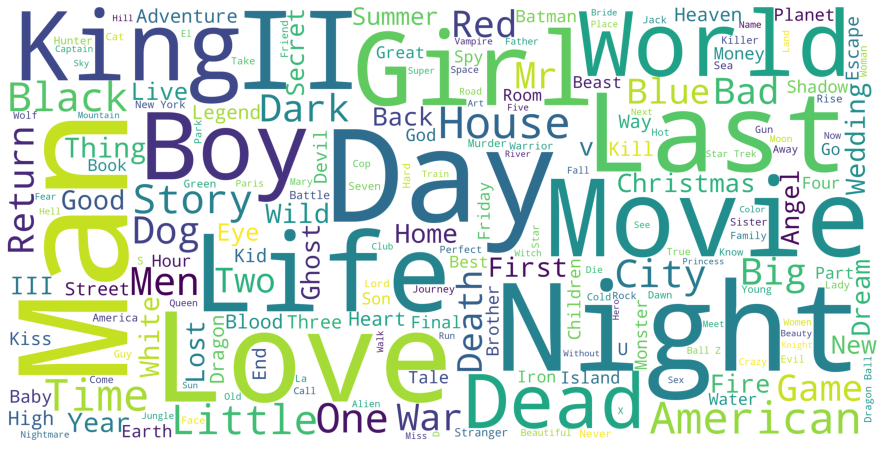

In [22]:
# Just some fancy thing
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

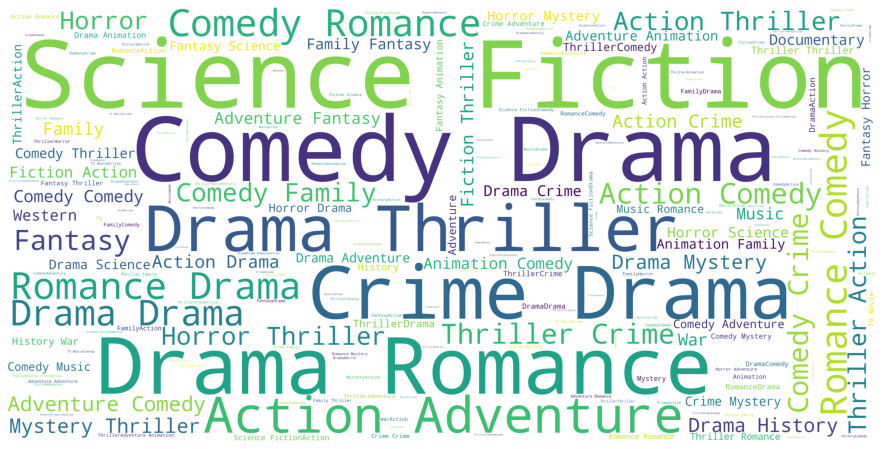

In [23]:
# Fancy thing ver 2.0, but here we can get a rough idea where we have many sci-fi, comedy and drama movies
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

<a class="anchor" id="2.2.1"></a>
### Have you ever wondered who directed the most movies?

From here, let's extract the `Director` columns and simply do a value_counts() on it.

In [24]:
# Number of movies directed by a particular director
director_counts = pd.DataFrame((merged_data.Director.iloc[:].str.split(', ').explode().value_counts()).iloc[1:]).reset_index()
director_counts.columns = ['Director','Movies_directed']
director_counts.head(10)

Director  Movies_directed
0        Woody Allen               38
1     Clint Eastwood               29
2   Alfred Hitchcock               29
3   Steven Spielberg               27
4         Ron Howard               23
5    Martin Scorsese               22
6  Steven Soderbergh               21
7       Ridley Scott               20
8          Joel Coen               19
9    Joel Schumacher               18

In [25]:
38.0/len(merged_data)

0.004702388318277441

We see that **Woody Allen** directed 38 of the movies in our dataset! That's like around **0.47%** of you to watch his movies if you choose to watch any of the movies from our dataframe!

<a class="anchor" id="2.2.2"></a>
### Top 10 Most Popular Movies

If you are a lazy on searching good movies, why don't you try to watch the popular movies watched by most of the people?

Let's take a look of them!

In [26]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [27]:
merged_data['popularity'] = merged_data['popularity'].apply(clean_numeric).astype('float')
merged_data['popularity'].describe()

count    8081.000000
mean       11.351876
std        14.152598
min         3.485213
25%         6.658994
50%         9.230460
75%        12.457896
max       547.488298
Name: popularity, dtype: float64

In [28]:
# By simply sorting the popularity, we then found the most popular movie
pop=merged_data[['Title','popularity','Year','Average_rating']].sort_values('popularity',ascending = False).head(10)
pop

Title  popularity  Year  \
5435                                            Minions  547.488298  2015   
5537                                           Ad Astra  463.487000  2019   
5141                                       Wonder Woman  294.337037  2017   
385                                Beauty and the Beast  287.253654  2017   
5539                                  Bad Boys for Life  255.068000  2020   
5538                                          Bloodshot  235.701000  2020   
5278                                         Big Hero 6  213.849907  2014   
5540  Birds of Prey (and the Fantabulous Emancipatio...  192.582000  2020   
5342                                           Deadpool  187.860492  2016   
4344                                             Avatar  185.070892  2009   

      Average_rating  
5435        2.900000  
5537        2.950000  
5141        4.000000  
385         3.754098  
5539        3.550000  
5538        3.600000  
5278        4.095238  
5540        3.550000  
5342        3.388889  
4344        3.641791

In [29]:
Popular=px.bar(pop, x='Title', y='popularity', color="Title", title="Top 10 Highest Popularity Movies")
Popular.update_layout(uniformtext_minsize=8)
Popular.update_layout(xaxis_tickangle=-38)

Click on this website if the plot does not load: https://drive.google.com/file/d/1ZpHFeWk-KuFuNmOhSaaKKCo0I7VbdQey/view?usp=sharing

Hmmm, maybe you can watch **Minions** this weekend.

<a class="anchor" id="2.2.3"></a>
### What's the most seen genres?

Sometimes, just sometimes, we found that most of the movies have similar genres - which are quite boring if we wanted a movies which will stand out and brighten up our sight.

Let's explore the genres we have.

In [30]:
# Genres in the Dataset
print("Number of Genres :", len(merged_data["Genres"].unique()))

# Movies in each Genres
print(merged_data["Genres"].str.split(', ').explode().value_counts().iloc[1:])

Number of Genres : 1870
Drama              3908
Comedy             2868
Thriller           2194
Action             1839
Romance            1440
Crime              1223
Adventure          1210
Horror              978
Science Fiction     902
Fantasy             788
Family              765
Mystery             700
Animation           469
History             339
Music               300
War                 245
Documentary         188
Western             132
TV Movie             70
Foreign               2
Name: Genres, dtype: int64


In [31]:
genre=merged_data[["Genres"]]
genre1=genre.assign(var1=genre['Genres'].str.split(', ')).explode('var1')
genre1=genre1.drop(['Genres'], axis=1)
genre1=genre1.rename(columns= {'var1' : 'genres'})
genre1=genre1['genres'].value_counts().reset_index()
genre1 = genre1.iloc[1:]
genre1=genre1.rename(columns= {'genres' : 'Count'})
genre1=genre1.rename(columns= {'index' : 'genres'})
CountGen=genre1

In [32]:
Genr=px.bar(genre1, x='genres', y='Count', color="genres", title='Genres Count')
Genr.update_layout(uniformtext_minsize=8)
Genr.update_layout(xaxis_tickangle=-38)

Click on this website if the plot does not load: https://drive.google.com/file/d/1k2VM5GQdBhjzBkEWuhpr9usHlQReyHm6/view?usp=sharing

Wowowow! Do most watched **Drama**?? Me too!! Although they watched, they might not love. But I love Dramasss! OOPS Kekeke!

In [33]:
genre=merged_data[["Genres", "Average_rating", "Title", "Year"]]
genre1=genre.assign(var1=genre['Genres'].str.split(', ')).explode('var1')
genre1=genre1.drop(['Genres'], axis=1)
genre1=genre1.rename(columns= {'var1' : 'genres'})
genre1=genre1[((genre1.genres != ''))]
genre2 = genre1.pivot_table('Average_rating', genre1.index, 'genres')
genre2.describe().round(2)

genres   Action  Adventure  Animation   Comedy    Crime  Documentary    Drama  \
count   1839.00    1210.00     469.00  2868.00  1223.00       188.00  3908.00   
mean       3.08       3.17       3.36     3.12     3.23         3.63     3.39   
std        0.78       0.76       0.75     0.80     0.78         0.81     0.77   
min        0.00       0.00       0.00     0.00     0.00         0.00     0.00   
25%        2.67       2.80       3.00     2.75     2.85         3.45     3.00   
50%        3.17       3.27       3.50     3.25     3.35         3.80     3.50   
75%        3.57       3.65       3.83     3.67     3.77         4.00     3.89   
max        5.00       5.00       5.00     5.00     5.00         5.00     5.00   

genres  Family  Fantasy  Foreign  History  Horror   Music  Mystery  Romance  \
count   765.00   788.00     2.00   339.00  978.00  300.00   700.00  1440.00   
mean      3.10     3.18     2.88     3.60    2.94    3.37     3.28     3.28   
std       0.81     0.74     1.24     0.64    0.84    0.75     0.74     0.77   
min       0.00     0.00     2.00     0.00    0.00    0.00     0.00     0.00   
25%       2.75     2.80     2.44     3.30    2.50    3.13     2.90     2.95   
50%       3.25     3.25     2.88     3.67    3.00    3.50     3.34     3.40   
75%       3.62     3.65     3.31     4.00    3.50    3.83     3.79     3.75   
max       5.00     5.00     3.75     5.00    5.00    5.00     5.00     5.00   

genres  Science Fiction  TV Movie  Thriller     War  Western  
count            902.00     70.00   2194.00  245.00   132.00  
mean               3.10      3.12      3.12    3.50     3.45  
std                0.77      1.02      0.79    0.69     0.59  
min                0.00      0.00      0.00    0.00     1.83  
25%                2.72      2.54      2.72    3.15     3.13  
50%                3.17      3.35      3.20    3.60     3.50  
75%                3.57      3.75      3.63    4.00     3.83  
max                5.00      5.00      5.00    5.00     5.00

In [34]:
px.box(genre1, x='Average_rating', y='genres', hover_data=['Title'], color='genres')

Click on this website if the plot does not load: https://drive.google.com/file/d/1AUt4seuZt4-KmdKVouX3wyoKdWqQ2Cct/view?usp=sharing

Overall, we found that most of the movies are in Drama.

In [35]:
from pandas import DataFrame
x=genre1.groupby('genres')['Average_rating'].mean()
a=DataFrame(x)
a['Genres']=a.index
a=a.sort_values('Average_rating',ascending = False)
b=genre1['genres'].value_counts().reset_index()
b=b.rename(columns= {'genres' : 'Count'})
b=b.rename(columns= {'index' : 'genres'})
a=a.merge(b[['genres', 'Count']], how='inner', on='genres')
ge=px.bar(a, x='Genres', y='Average_rating', color='Average_rating', title='Average Rating for each Genres', hover_data=['Count'])
ge.update_layout(uniformtext_minsize=8)
ge.update_layout(xaxis_tickangle=-38)

Click on this website if the plot does not load: https://drive.google.com/file/d/1hrBgoFo04mM-MwmKDRITpA9Homc-uBVl/view?usp=sharing

What!? **Documentary** has the highest rating?? But there's only 188 people rated!

Genres are arranged according to number of counts in descending order.

In [36]:
CountGen['index']=[chr(ord('a') + x).upper() for x in CountGen.index]
genre1=genre1.merge(CountGen[['index', 'genres']], how='inner', on='genres')
genre1['Year_Genres']=genre1['Year'].map(str) + ', ' +genre1['index'].map(str)
g=genre1.groupby('Year_Genres')['Average_rating'].mean()
g=DataFrame(g)
g.reset_index(inplace=True)
g= g.rename(columns= { 'Average_rating' : 'Avg Rating'})
d=pd.DataFrame(g.Year_Genres.str.split(', ',1).tolist(),columns=['Year', 'Genres'])
GenYear=genre1.drop(['Average_rating', 'Title'], axis=1)
GenYear=GenYear.merge(g[['Avg Rating', 'Year_Genres']], how='inner', on='Year_Genres')
GenYear=GenYear.drop_duplicates()
GenYear=GenYear.merge(CountGen[['Count', 'genres']], how='inner', on='genres')
GenYear=GenYear.sort_values('Year_Genres',ascending = True)
gerr=px.bar(GenYear, x='genres', y='Avg Rating', title='Avg Rating per Genres over the years', animation_frame='Year', color='Avg Rating', hover_data=['Count'])
gerr.update_layout(uniformtext_minsize=8)
gerr.update_layout(xaxis_tickangle=-38)

<a class="anchor" id="2.2.4"></a>
### What are the most used languages then?

Guess what language you will need to learn next :')

In [37]:
# Languages in the Dataset
print("Number of Languages :", len(merged_data["Available Languages"].unique()))

# Movies in each Languages
print(merged_data["Available Languages"].str.split(', ').explode().value_counts().iloc[1:41])
#sb.catplot(y = "Available Languages", data = merged_data, kind = "count")

Number of Languages : 905
                    6437
Français             824
Español              635
Deutsch              481
Italiano             394
Pусский              307
日本語                  296
普通话                  175
Português            122
العربية              110
广州话 / 廣州話             91
Latin                 86
Magyar                84
한국어/조선말               73
Polski                68
svenska               60
Český                 59
ภาษาไทย               54
हिन्दी                43
עִבְרִית              43
Dansk                 37
ελληνικά              35
Türkçe                32
Tiếng Việt            29
Norsk                 27
Nederlands            26
Bahasa indonesia      22
فارسی                 21
Română                20
suomi                 15
اردو                  14
Gaeilge               14
Український           13
Kiswahili             12
Srpski                12
Íslenska              10
Hrvatski               9
தமிழ்                  8
Afrikaans              8

In [38]:
Language=merged_data[["Available Languages", "Average_rating"]]
Language=Language.assign(var1=Language['Available Languages'].str.split(', ')).explode('var1')
Language=Language.drop(['Available Languages'], axis=1)
Language=Language.rename(columns= {'var1' : 'Available Languages'})

In [39]:
Language1 = Language.pivot_table('Average_rating', Language.index, 'Available Languages')
Language1=Language1.drop([''], axis=1)
Language1.describe().round(2)

Available Languages  Afrikaans  Bahasa indonesia  Bahasa melayu  Bosanski  \
count                     8.00             22.00           4.00      5.00   
mean                      3.44              2.90           3.27      3.61   
std                       0.62              1.14           0.50      0.44   
min                       2.15              0.00           2.56      2.90   
25%                       3.19              2.61           3.12      3.54   
50%                       3.60              3.05           3.40      3.75   
75%                       3.85              3.60           3.55      3.80   
max                       4.04              4.25           3.70      4.05   

Available Languages  Català  Cymraeg  Dansk  Deutsch  Eesti  English  ...  \
count                  4.00     5.00  37.00   481.00   3.00  7227.00  ...   
mean                   3.96     2.42   3.49     3.44   3.59     3.19  ...   
std                    0.42     1.47   0.57     0.75   0.42     0.79  ...   
min                    3.50     0.00   2.00     0.00   3.15     0.00  ...   
25%                    3.75     2.50   3.00     3.00   3.39     2.80  ...   
50%                    3.92     2.50   3.50     3.50   3.62     3.30  ...   
75%                    4.12     3.25   3.91     4.00   3.81     3.73  ...   
max                    4.50     3.88   4.50     5.00   4.00     5.00  ...   

Available Languages  বাংলা  ਪੰਜਾਬੀ  தமிழ்  తెలుగు  ภาษาไทย  ქართული  \
count                  1.0    6.00   8.00    4.00    54.00     1.00   
mean                   3.0    2.61   3.43    3.09     2.98     3.95   
std                    NaN    1.39   0.34    0.63     0.85      NaN   
min                    3.0    0.00   2.95    2.15     0.50     3.95   
25%                    3.0    2.34   3.29    3.05     2.50     3.95   
50%                    3.0    3.13   3.38    3.35     3.22     3.95   
75%                    3.0    3.47   3.57    3.39     3.50     3.95   
max                    3.0    3.70   4.00    3.50     4.14     3.95   

Available Languages  广州话 / 廣州話     日本語     普通话  한국어/조선말  
count                    91.00  296.00  175.00    73.00  
mean                      3.39    3.41    3.37     3.33  
std                       0.79    0.85    0.70     0.65  
min                       0.00    0.00    0.00     0.50  
25%                       3.08    3.00    3.06     3.00  
50%                       3.50    3.57    3.50     3.31  
75%                       4.00    4.00    3.84     3.80  
max                       5.00    5.00    5.00     5.00  

[8 rows x 65 columns]

In [40]:
Lang10=merged_data[['Available Languages']]
Lang10=Lang10.assign(var1=Lang10['Available Languages'].str.split(', ')).explode('var1')
Lang10=Lang10.drop(['Available Languages'], axis=1)
Lang10=Lang10.rename(columns= {'var1' : 'Languages'})
Lang10=Lang10['Languages'].value_counts().reset_index().head(11)
Lang10 = Lang10.drop(Lang10.index[1])
Lang10=Lang10.rename(columns= {'Languages' : 'Count'})
Lang10=Lang10.rename(columns= {'index' : 'Languages'})

In [41]:
L=px.bar(Lang10, x='Languages', y='Count', color="Languages", title="Top 10 Most Available Language Count")
L.update_layout(uniformtext_minsize=8)
L.update_layout(xaxis_tickangle=-38)

Click on this website if the plot does not load: https://drive.google.com/file/d/1oS5nESUpUg7FyTLCI9ds45--tGHHSGZh/view?usp=sharing

Bonjour! More original language in **French** and others please!! :>

<a class="anchor" id="2.2.5"></a>
### Year and Ratings distributions

In [42]:
import plotly.graph_objects as go
from pandas import DataFrame
x=merged_data.groupby('Year')['Average_rating'].count()
a=DataFrame(x)
a['year']=a.index
px.line(a, x='year', y='Average_rating', labels={'Average_rating':'Count'}, title='Rating Counts over the years')

Click on this website if the plot does not load: https://drive.google.com/file/d/1N4Dpu6WlilwNp4EmQYeAYjStnTrLqql0/view?usp=sharing

Year **2019** has the most rating count of 601!

In [43]:
x=merged_data.groupby('Title')['Average_rating'].mean()
x=DataFrame(x)
x=x.merge(merged_data[['Year', 'Title']], how='inner', on='Title')
x=x.groupby('Year')['Average_rating'].mean()

In [44]:
a=DataFrame(x)
a['year']=a.index
px.line(a, x='year', y='Average_rating', title='Rating over the years')

Click on this website if the plot does not load: https://drive.google.com/file/d/1lTTbxC_wpLvXsB2KAx45fSDYBFTDkewj/view?usp=sharing

Year **2014** had the worst average rating after Year 2020 due to external factors. Click on the link to find out more: https://mashable.com/2014/12/31/2014-movies/

In [45]:
date=merged_data[["Year", "Average_rating", "Title"]]
merged_data=merged_data.replace(to_replace = "None", value = 1980)
merged_data["Year"] = pd.to_numeric(merged_data["Year"])
date=date.sort_values('Average_rating',ascending = True)
datescat = date
datescat1=date
bins = [0, 1981, 1991, 2001, 2011]
years = ['<1980', '1981-1990', '1991-2000', '2001-2010' , '2011-2020']
d = dict(enumerate(years, 1))
date['Year_range'] = np.vectorize(d.get)(np.digitize(date['Year'], bins))
date.head()

Year  Average_rating                                            Title  \
6584  2019             0.0  Kamen Rider Build NEW WORLD: Kamen Rider Grease   
6171  2019             0.0            More Beautiful for Having Been Broken   
6163  2020             0.0                                  Shooting Heroin   
7096  2020             0.0                     My Love Affair with Marriage   
5863  2020             0.0  Fate/Stay Night: Heaven's Feel III. Spring Song   

     Year_range  
6584  2011-2020  
6171  2011-2020  
6163  2011-2020  
7096  2011-2020  
5863  2011-2020

In [46]:
date1 = date.pivot_table('Average_rating', date.index, 'Year_range')
date1.insert(0, '<1980', date1.pop('<1980'))
date1.describe().round(2)

Year_range   <1980  1981-1990  1991-2000  2001-2010  2011-2020
count       842.00     878.00    1531.00    2045.00    2785.00
mean          3.67       3.32       3.21       3.19       3.09
std           0.59       0.76       0.70       0.85       0.86
min           0.50       0.50       0.50       0.50       0.00
25%           3.41       2.98       2.83       2.75       2.75
50%           3.75       3.47       3.29       3.30       3.20
75%           4.00       3.83       3.69       3.75       3.60
max           5.00       5.00       5.00       5.00       5.00

Hover on the graph to find out more on the specific movies having the highest (or lowest, etc) rating!

In [47]:
date=date.sort_values('Year_range',ascending = True)
px.box(date, x='Average_rating', y='Year_range', hover_data=['Title'])

Click on this website if the plot does not load: https://drive.google.com/file/d/1NaMdsh5dktGYNaMMVzt5OWavOBnBdewK/view?usp=sharing

Seems like movies **<1980** have higher median rating!

<AxesSubplot:title={'center':'Number of Movies released in a particular Year Range'}, xlabel='Year_range', ylabel='count'>

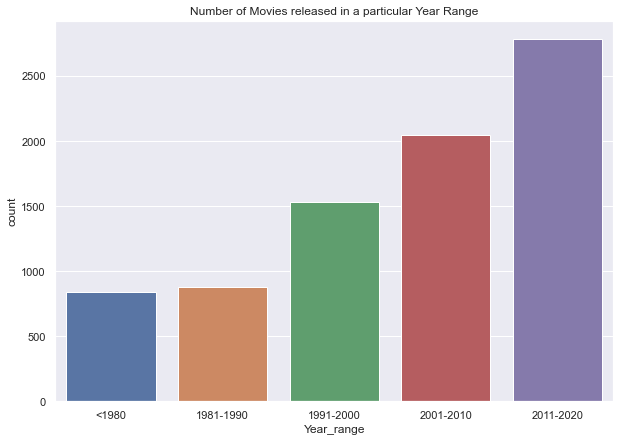

In [48]:
f = plt.figure(figsize = (10,7))
plt.title("Number of Movies released in a particular Year Range")
sb.countplot(x = 'Year_range', data = date, order = years)

In [49]:
date1.describe()

Year_range       <1980   1981-1990    1991-2000    2001-2010    2011-2020
count       842.000000  878.000000  1531.000000  2045.000000  2785.000000
mean          3.666139    3.315524     3.208943     3.185321     3.086673
std           0.591424    0.760776     0.698010     0.845200     0.859001
min           0.500000    0.500000     0.500000     0.500000     0.000000
25%           3.410179    2.978571     2.833333     2.750000     2.750000
50%           3.750000    3.465625     3.291667     3.300000     3.200000
75%           4.000000    3.833333     3.692982     3.750000     3.600000
max           5.000000    5.000000     5.000000     5.000000     5.000000

In [50]:
datescat=datescat1
datescat=datescat['Year'].value_counts().reset_index()
datescat = datescat.rename(columns={"Year": "No. of movies that year"})
datescat = datescat.rename(columns={"index": "Year"})
datescat1=datescat1.merge(datescat[['Year', 'No. of movies that year']], how='inner', on='Year')

In [51]:
px.scatter(datescat1, x='Year', y='Average_rating', hover_data=['Title', 'No. of movies that year'], color='Average_rating', title="Average Rating vs Year")

Hover on the graph to find out more on the specific movies having the highest (or lowest, etc) rating!

Click on this website if the plot does not load: https://drive.google.com/file/d/1F9wbaEJbOb51OAOEWKqEe0XZuBOq68DJ/view?usp=sharing

<a class="anchor" id="2.2.6"></a>
### Again, Runtime

In [52]:
run=merged_data[["runtime", "Average_rating"]]
run=run[run["runtime"]>40]
run.describe()

runtime  Average_rating
count  8081.000000     8081.000000
mean    107.346244        3.220044
std      24.531777        0.809090
min      42.000000        0.000000
25%      94.000000        2.842857
50%     104.000000        3.333333
75%     117.000000        3.750000
max     877.000000        5.000000

In [53]:
bins = [0, 91, 121, 151, 181, 211]
time = ['<91', '91-120', '121-150', '151-180', '181-210', '210+']

d = dict(enumerate(time, 1))

run['Time_range'] = np.vectorize(d.get)(np.digitize(run['runtime'], bins))
run=run.drop(['runtime'], axis=1)
run.head()

Average_rating Time_range
0        3.872470        <91
1        3.401869     91-120
2        3.161017     91-120
3        2.384615    121-150
4        3.267857     91-120

In [54]:
run1 = run.pivot_table('Average_rating', run.index, 'Time_range')
run1=run1[['<91', '91-120', '121-150', '151-180', '181-210', '210+']]

Time_range      <91   91-120  121-150  151-180  181-210   210+
count       1395.00  5108.00  1330.00   179.00    44.00  25.00
mean           3.01     3.19     3.46     3.63     3.77   3.85
std            0.94     0.79     0.67     0.59     0.47   0.78
min            0.00     0.00     0.00     0.00     2.87   2.00
25%            2.50     2.81     3.14     3.40     3.45   3.50
50%            3.10     3.29     3.50     3.66     3.87   4.00
75%            3.65     3.73     3.89     3.98     4.03   4.25
max            5.00     5.00     5.00     5.00     5.00   5.00

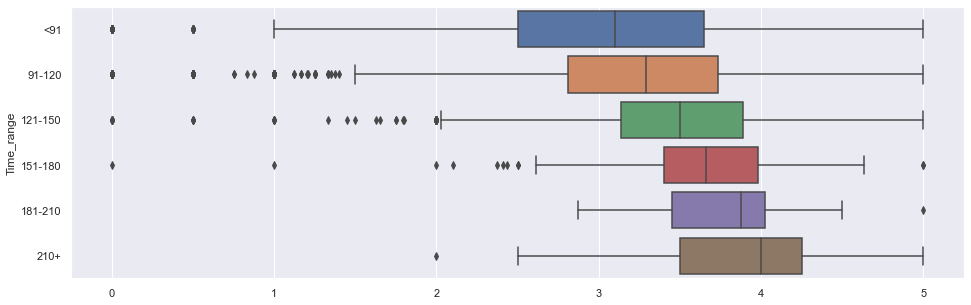

In [55]:
f = plt.figure(figsize=(16,5))
sb.boxplot(data = run1, orient = "h")
run1.describe().round(2)

Runtime on density plot:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='runtime', ylabel='Density'>

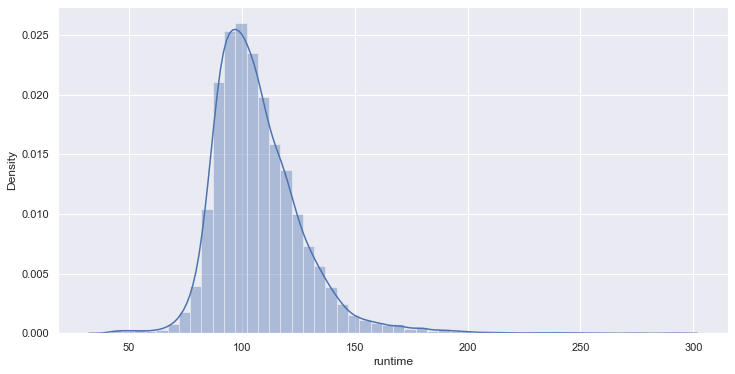

In [56]:
plt.figure(figsize=(12,6))
sb.distplot(merged_data[(merged_data['runtime'] < 300) & (merged_data['runtime'] > 0)]['runtime'])

More movies have runtime about **100** minutes!

In [57]:
run1.describe()

Time_range          <91       91-120      121-150     151-180    181-210  \
count       1395.000000  5108.000000  1330.000000  179.000000  44.000000   
mean           3.012601     3.191177     3.463207    3.629682   3.774131   
std            0.941091     0.788554     0.669827    0.592557   0.466309   
min            0.000000     0.000000     0.000000    0.000000   2.869048   
25%            2.500000     2.808007     3.138170    3.400000   3.448359   
50%            3.100000     3.291667     3.500000    3.660494   3.874599   
75%            3.647917     3.734992     3.886125    3.983081   4.025000   
max            5.000000     5.000000     5.000000    5.000000   5.000000   

Time_range       210+  
count       25.000000  
mean         3.849167  
std          0.781558  
min          2.000000  
25%          3.500000  
50%          4.000000  
75%          4.250000  
max          5.000000

<a class="anchor" id="2.2.7"></a>
### Country

In [58]:
# Country in the Dataset
print("Number of Country:", len(merged_data["Country"].unique()))

# Movies in each Country
print(merged_data["Country"].str.split(', ').explode().value_counts().iloc[1:11])

Number of Country: 822
United States of America    6278
United Kingdom              1131
France                       638
Germany                      472
Canada                       387
Japan                        258
Italy                        205
Australia                    158
Spain                        154
China                        107
Name: Country, dtype: int64


In [59]:
country=merged_data[["Country"]]
country1=country.assign(var1=country['Country'].str.split(', ')).explode('var1')
country1=country1.drop(['Country'], axis=1)
country1= country1.rename(columns= { 'var1' : 'Country'})
country1=country1['Country'].value_counts().reset_index().head(11)
country1 = country1.iloc[1:11]
country1=country1.rename(columns= {'Country' : 'Count'})
country1=country1.rename(columns= {'index' : 'Country'})

In [60]:
c=px.bar(country1, x='Country', y='Count', color='Country', title='Top 10 countries count')
c.update_layout(uniformtext_minsize=8)
c.update_layout(xaxis_tickangle=-38)

Click on this website if the plot does not load: https://drive.google.com/file/d/1UhgaxT_DBxtnTAMZ188CPUGMxnqTpIyZ/view?usp=sharing

Wow! USA produces the most number of movies overall! Like... **6278**?? Amazing!!

<a class="anchor" id="2.3"></a>
### Relations between variables

In [61]:
relation=merged_data[['popularity', 'Year', 'runtime', 'Average_rating']]
relation.head()

popularity  Year  runtime  Average_rating
0   21.946943  1995     81.0        3.872470
1   17.015539  1995    104.0        3.401869
2   11.712900  1995    101.0        3.161017
3    3.859495  1995    127.0        2.384615
4    8.387519  1995    106.0        3.267857

popularity      Year   runtime  Average_rating
popularity        1.000000  0.167182  0.079548        0.031233
Year              0.167182  1.000000 -0.050003       -0.205679
runtime           0.079548 -0.050003  1.000000        0.184308
Average_rating    0.031233 -0.205679  0.184308        1.000000

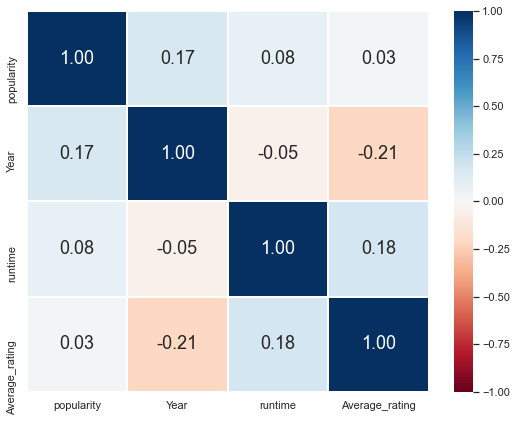

In [62]:
plt.figure(figsize=(9,7))
sb.heatmap(relation.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")
relation.corr()

Seemingly weak correlations! :/

[Back to Content Page](#0.0)

And that's the end of our EDA. Next, we proceed to our **Movie Recommender**.

<a class="anchor" id="3.1"></a>
# Collaborative Filtering
In this initial segment of the code, our goal is to create a user profile and attempt to sieve out some movies a users might enjoy. Techniques utilised include <b>Singular Vector Decomposition (Truncated), Matrix Factorization, Nearest Neighbors and Alternating Least Squares (Brief Insight)</b>

In [63]:
# We will first import our basic modules and packages
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from pandas.core.common import SettingWithCopyWarning
from pandas.core.common import SettingWithCopyWarning
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', message="^Columns.*")
#merged_data = pd.read_csv('merged_data.csv')

This part involves obtaining <b>filtering out all movies and users without a rating</b> (as we want each movie and user to have given a rating before). Subsequently. we will convert out results into a pivot table and store it in `rating_table`

In [64]:
link1 = pd.read_csv('links_new.csv')
rate1 = pd.read_csv('ratings_small_new.csv')
rate1 = rate1.drop(columns = 'timestamp')
merged_2[merged_2['id1'].isnull()]

movies = movies.append(rate1)
merged_data = merged_2
merged_data = merged_data.rename(columns = {'imdbId1':'imdbId','id1':'id'})
merged_data

movieId   imdbId        id                                       Genres  \
0           1   114709     862.0                  Animation, Comedy, Family,    
1           2   113497    8844.0                 Adventure, Fantasy, Family,    
2           3   113228   15602.0                            Romance, Comedy,    
3           4   114885   31357.0                     Comedy, Drama, Romance,    
4           5   113041   11862.0                                     Comedy,    
...       ...      ...       ...                                          ...   
8284   105835  1825157  146015.0                   Fantasy, Science Fiction,    
8285   105844  2024544   76203.0  Music, Adventure, Fantasy, Comedy, Family,    
8286   105954  2017038  152747.0                          Animation, Family,    
8287   106002  1731141   80274.0                             Drama, Romance,    
8288   106062  3063516  208134.0                    Comedy, Science Fiction,    

                                               Overview  popularity  \
0     Led by Woody, Andy's toys live happily in his ...   21.946943   
1     When siblings Judy and Peter discover an encha...   17.015539   
2     A family wedding reignites the ancient feud be...   11.712900   
3     Cheated on, mistreated and stepped on, the wom...    3.859495   
4     Just when George Banks has recovered from his ...    8.387519   
...                                                 ...         ...   
8284  There is a war in the world between the men an...    9.216100   
8285  Doctor Gulliver is poor, so nothing - not even...    8.158266   
8286  Sam the snowman tells us the story of a young ...    7.129761   
8287  Bobby Deerfield, a famous American race car dr...    5.792931   
8288  Shurik Timofeev builds a working model of a ti...    4.700685   

                                     Production Company  \
0                             Pixar Animation Studios,    
1     TriStar Pictures, Teitler Film, Interscope Com...   
2                        Warner Bros., Lancaster Gate,    
3              Twentieth Century Fox Film Corporation,    
4          Sandollar Productions, Touchstone Pictures,    
...                                                 ...   
8284  Bioskop-Film GmbH, Nouvelles Éditions de Films...   
8285       Columbia Pictures, Morningside Productions,    
8286  Rankin/Bass Productions, Videocraft Internatio...   
8287  Columbia Pictures Corporation, First Artists, ...   
8288                                          Mosfilm,    

                                         Country  Year  runtime  \
0                     United States of America,   1995     81.0   
1                     United States of America,   1995    104.0   
2                     United States of America,   1995    101.0   
3                     United States of America,   1995    127.0   
4                     United States of America,   1995    106.0   
...                                          ...   ...      ...   
8284                           Germany, France,   1975    100.0   
8285  United Kingdom, United States of America,   1960    100.0   
8286                  United States of America,   1964     52.0   
8287                  United States of America,   1977    124.0   
8288                                    Russia,   1973     93.0   

      Available Languages                                    Title  \
0               English,                                 Toy Story   
1     English, Français,                                   Jumanji   
2               English,                          Grumpier Old Men   
3               English,                         Waiting to Exhale   
4               English,               Father of the Bride Part II   
...                   ...                                      ...   
8284  English, Français,                                Black Moon   
8285  English, Français,                  The 3 Worlds of Gulliver   
8286            English,           R

In [65]:
movie_rating = pd.merge(movies,pd.merge(link,merged_data[['Title','imdbId']], on='imdbId' ),on='movieId')


movie_ratingCount = movie_rating.groupby(by = ['userId'])['rating'].count().reset_index().rename(columns={"rating":"totalRatingCount"})
movie_ratingCount = pd.merge(movie_rating, movie_ratingCount, on = 'userId')
movie_ratingCount = movie_ratingCount.sort_values(by=['userId'])
movie_ratingCount
popularity_threshold = 1
rating_popular = movie_ratingCount.query('totalRatingCount >= @popularity_threshold')


movie_ratingCount = (rating_popular.groupby(by = ['Title'])['rating'].count().reset_index().rename(columns={"rating":"totalRatingsCount"}))
movie_ratingCount = pd.merge(rating_popular, movie_ratingCount, on = 'Title')
movie_ratingCount = movie_ratingCount.sort_values(by=['movieId'])
popularity_threshold = 1
rating_popular = movie_ratingCount.query('totalRatingsCount >= @popularity_threshold')
rating_popular.head()
rating_table = rating_popular.pivot_table(index='Title',columns='userId',values='rating').fillna(0)
rating_table

userId                   1     2     3     4     5     6     7     8     9     \
Title                                                                           
#RealityHigh              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
'83                       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
(500) Days of Summer      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...And Justice for All    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10                        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                       ...   ...   ...   ...   ...   ...   ...   ...   ...   
eXistenZ                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
mid90s                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
xXx: State of the Union   0.0   0.0   0.0   0.0   0.0   1.5   0.0   0.0   0.0   
È per il tuo bene         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Смотри как я              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

userId                   10    ...  1272  1273  1274  1275  1276  1277  1278  \
Title                          ...                                             
#RealityHigh              0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
'83                       0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
(500) Days of Summer      0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...And Justice for All    0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10                        0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                       ...  ...   ...   ...   ...   ...   ...   ...   ...   
eXistenZ                  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
mid90s                    0.0  ...   0.0   0.0   0.0   0.0   4.0   0.0   0.0   
xXx: State of the Union   0.0  ...   0.0   0.0   4.0   0.0   0.0   0.0   0.0   
È per il tuo bene         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Смотри как я              0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

userId                   1279  1280  1281  
Title                                      
#RealityHigh              0.0   0.0   0.0  
'83                       0.0   0.0   0.0  
(500) Days of Summer      0.0   0.0   0.0  
...And Justice for All    0.0   0.0   0.0  
10                        0.0   0.0   3.0  
...                       ...   ...   ...  
eXistenZ                  0.0   0.0   0.0  
mid90s                    0.0   0.0   0.0  
xXx: State of the Union   3.0   0.0   3.5  
È per il tuo bene         0.0   0.0   3.5  
Смотри как я              0.0   0.0   0.0  

[6345 rows x 1281 columns]

### Choosing Genres and Year Range
We will create a new user `1282` and ask the user to pick a few genres.
`genre`: Takes in the different Genres a user wants to consider (Format: eg. War Animation Fantasy)
`year`: Takes in a Year and filters all movies above that year (inclusive)

In [66]:
genre_types = list(merged_data["Genres"].str.split(', ').explode().unique())
genre_types.pop(3)
rating_table[1281] = 0
print("Available Genres are:")
for i in genre_types:
    print(i)
genre = input("Please enter some Genres: ").split()
year = int(input("Please enter a Year and above: "))

Available Genres are:
Animation
Comedy
Family
Adventure
Fantasy
Romance
Drama
Action
Crime
Thriller
Horror
History
Science Fiction
Mystery
War
Music
Documentary
Western
TV Movie
Foreign
Please enter some Genres: Action Adventure
Please enter a Year and above: 2010


`movies_with_rating` is a DataFrame that contains only movies that <b>have been rated before</b>

In [67]:
movie_with_rating = list(rating_table.index)
movies_with_rating = merged_data.loc[merged_data['Title'].isin(movie_with_rating)]

`year_filter` and `genre_filter` contains the Filtered Dataset based on Year and Genre that <b>we chose</b> earlier

In [68]:
genre_filter = movies_with_rating[movies_with_rating['Genres'].str.contains('|'.join(genre))]
genre_filter['Year'] = pd.to_numeric(genre_filter['Year'])
year_filter = genre_filter[genre_filter['Year'] > year]
# Resetting the index
year_filter = year_filter.reset_index().drop(columns=['index'])

Let us choose and rate 5 movies. Indicate 0 for a movie if it is unwatched.

In [70]:
condition = 5
titles = []
while condition > 0:
    stage_1 = random.sample(range(0, len(year_filter)), 5)
    stage_1_filter = year_filter.iloc[stage_1].reset_index().drop(columns=['index'])
    extract_title = stage_1_filter['Title']
    for i in extract_title:
        result = float(input("Input your rating score for {}: ".format(i)))
        if result > 0:
            rating_table[1281][rating_table.index == i] = result
            titles.append(i)
            condition-=1
        else:
            rating_table[1281][rating_table.index == i] = 0
        if condition == 0:
            break
            
rating_table2 = rating_table.copy()
myrated = list(stage_1_filter['Title'])
print("\n\033[1mThe Movies you rated are:\033[0m")
for i in titles:
    print(i)

Input your rating score for Torpedo: 0
Input your rating score for Jo Pil-ho: The Dawning Rage: 0
Input your rating score for My Hero Academia: Two Heroes: 3.5
Input your rating score for Bad Asses on the Bayou: 0
Input your rating score for Star Wars: The Force Awakens: 5
Input your rating score for Tenet: 5
Input your rating score for Daughter of the Wolf: 0
Input your rating score for Total Recall: 2.5
Input your rating score for Artemis Fowl: 3

The Movies you rated are:
My Hero Academia: Two Heroes
Star Wars: The Force Awakens
Tenet
Total Recall
Artemis Fowl


<a class="anchor" id="3.1.2"></a>
## Imputation of Values
As we can notice, our `rating_table` is currently a sparse matrix filled with many 0's (due to missing matrix). We will try to impute user-movie matrix via:
* <b>Total Movie Average + User Bias + Movie Bias</b>

<b>Note: </b>This code takes roughly 25 minutes to run due to the imputation of the values. An alternative is to just skip this imputation segment and go to the TruncatedSVD portion. Input ~650 components (Due to explained variance being around 0.95). Results are slightly poorer however still acceptable. Furthermore this is because TruncatedSVD is designed to work on sparse matrices as well


In [72]:
all_movie_average = 0
entries = 0
for i in range(0, rating_table.shape[0]):
    all_movie_average += sum(rating_table.iloc[i][rating_table.iloc[i] != 0])
    entries += len(rating_table.iloc[i][rating_table.iloc[i] != 0])

all_movie_average = all_movie_average/entries

movie_mean = []
for i in range(0, rating_table.shape[0]):
    mean = sum(rating_table.iloc[i][rating_table.iloc[i] != 0])/len(rating_table.iloc[i][rating_table.iloc[i] != 0])
    movie_mean.append(mean)
    
for i in rating_table:
    print("Column",i,"is done...")
    mean = sum(rating_table[i])/len(rating_table[i][rating_table[i] > 0])
    movie_id = 0
    for j in rating_table[i]:
        if j == 0:
            rating_table[i][movie_id] = all_movie_average + mean - all_movie_average + movie_mean[movie_id] - all_movie_average
        movie_id +=1

Column 1 is done...
Column 2 is done...
Column 3 is done...
Column 4 is done...
Column 5 is done...
Column 6 is done...
Column 7 is done...
Column 8 is done...
Column 9 is done...
Column 10 is done...
Column 11 is done...
Column 12 is done...
Column 13 is done...
Column 14 is done...
Column 15 is done...
Column 16 is done...
Column 17 is done...
Column 18 is done...
Column 19 is done...
Column 20 is done...
Column 21 is done...
Column 22 is done...
Column 23 is done...
Column 24 is done...
Column 25 is done...
Column 26 is done...
Column 27 is done...
Column 28 is done...
Column 29 is done...
Column 30 is done...
Column 31 is done...
Column 32 is done...
Column 33 is done...
Column 34 is done...
Column 35 is done...
Column 36 is done...
Column 37 is done...
Column 38 is done...
Column 39 is done...
Column 40 is done...
Column 41 is done...
Column 42 is done...
Column 43 is done...
Column 44 is done...
Column 45 is done...
Column 46 is done...
Column 47 is done...
Column 48 is done...
C

Column 379 is done...
Column 380 is done...
Column 381 is done...
Column 382 is done...
Column 383 is done...
Column 384 is done...
Column 385 is done...
Column 386 is done...
Column 387 is done...
Column 388 is done...
Column 389 is done...
Column 390 is done...
Column 391 is done...
Column 392 is done...
Column 393 is done...
Column 394 is done...
Column 395 is done...
Column 396 is done...
Column 397 is done...
Column 398 is done...
Column 399 is done...
Column 400 is done...
Column 401 is done...
Column 402 is done...
Column 403 is done...
Column 404 is done...
Column 405 is done...
Column 406 is done...
Column 407 is done...
Column 408 is done...
Column 409 is done...
Column 410 is done...
Column 411 is done...
Column 412 is done...
Column 413 is done...
Column 414 is done...
Column 415 is done...
Column 416 is done...
Column 417 is done...
Column 418 is done...
Column 419 is done...
Column 420 is done...
Column 421 is done...
Column 422 is done...
Column 423 is done...
Column 424

Column 752 is done...
Column 753 is done...
Column 754 is done...
Column 755 is done...
Column 756 is done...
Column 757 is done...
Column 758 is done...
Column 759 is done...
Column 760 is done...
Column 761 is done...
Column 762 is done...
Column 763 is done...
Column 764 is done...
Column 765 is done...
Column 766 is done...
Column 767 is done...
Column 768 is done...
Column 769 is done...
Column 770 is done...
Column 771 is done...
Column 772 is done...
Column 773 is done...
Column 774 is done...
Column 775 is done...
Column 776 is done...
Column 777 is done...
Column 778 is done...
Column 779 is done...
Column 780 is done...
Column 781 is done...
Column 782 is done...
Column 783 is done...
Column 784 is done...
Column 785 is done...
Column 786 is done...
Column 787 is done...
Column 788 is done...
Column 789 is done...
Column 790 is done...
Column 791 is done...
Column 792 is done...
Column 793 is done...
Column 794 is done...
Column 795 is done...
Column 796 is done...
Column 797

Column 1119 is done...
Column 1120 is done...
Column 1121 is done...
Column 1122 is done...
Column 1123 is done...
Column 1124 is done...
Column 1125 is done...
Column 1126 is done...
Column 1127 is done...
Column 1128 is done...
Column 1129 is done...
Column 1130 is done...
Column 1131 is done...
Column 1132 is done...
Column 1133 is done...
Column 1134 is done...
Column 1135 is done...
Column 1136 is done...
Column 1137 is done...
Column 1138 is done...
Column 1139 is done...
Column 1140 is done...
Column 1141 is done...
Column 1142 is done...
Column 1143 is done...
Column 1144 is done...
Column 1145 is done...
Column 1146 is done...
Column 1147 is done...
Column 1148 is done...
Column 1149 is done...
Column 1150 is done...
Column 1151 is done...
Column 1152 is done...
Column 1153 is done...
Column 1154 is done...
Column 1155 is done...
Column 1156 is done...
Column 1157 is done...
Column 1158 is done...
Column 1159 is done...
Column 1160 is done...
Column 1161 is done...
Column 1162

<a class="anchor" id="3.1.3"></a>
## Truncated Singular Vector Decomposition
We will now perform a Truncated SVD on our Rating Table Matrix in order to better estimate the ratings of user. This is done through reducing the latent factors. <b>From the Theory of Linear Algebra, there exist a decompsition of X such that U and V are orthogonal matrices and Sigma is a diagonal matrix</b>. This process is called SVD
/dimensions\begin{matrix}X=U\Sigma V^{T}\end{matrix}


`sklearn.decomposition.TruncatedSVD` advantage over normal SVD, is that it allows us to directly select how many latent features we want to eliminante

In [73]:
from numpy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [74]:
userfocus = rating_table.transpose()

R = userfocus.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)

We will now try to decide how many components to reduce by comparing ratings predicted using Truncated SVD at different component counts. Ideally we want to keep about 95% of our explained variance. We have coded a `RMSE` function to do this

### Disclaimer: This code takes quite a while to run (Around 10 minutes)
This is due to the large data size we have

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(movie_rating, train_size=0.25)
X_train = X_train.reset_index()

In [77]:
def RMSE(actual, predicted):
    rmse = 0
    for i in range(actual.shape[0]):
        rmse+=(predicted[actual.iloc[i]['Title']][actual.iloc[i]['userId']] - actual.iloc[i]['rating'])**2
    rmse = (rmse/actual.shape[0])**0.5
    return rmse

In [78]:
# PURE TESTING
x = []
y = []
z = []
for i in range(40, 45):
    svd = TruncatedSVD(n_components=i)
    svd.fit(R)
    sum(svd.explained_variance_ratio_)
    all_user_predicted_ratings = svd.inverse_transform(svd.transform(R))
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating_table.index, index=rating_table.columns)
    x.append(i)
    y.append(RMSE(X_train, preds_df))
    z.append(abs(y[-1] - RMSE(X_test, preds_df)))
    print(i, "Train RMSE:",y[-1] , "Test RMSE", RMSE(X_test, preds_df), "Difference:", abs(y[-1] - RMSE(X_test, preds_df)))

40 Train RMSE: 0.6904681435571921 Test RMSE 0.6896578801742869 Difference: 0.0008102633829052408
41 Train RMSE: 0.6876900330369327 Test RMSE 0.686769604395201 Difference: 0.0009204286417316965
42 Train RMSE: 0.6848420246573043 Test RMSE 0.6842331659292284 Difference: 0.0006088587280758118
43 Train RMSE: 0.6825554205125853 Test RMSE 0.6818435506898773 Difference: 0.0007118698227079889
44 Train RMSE: 0.6795622587898126 Test RMSE 0.6792572637719753 Difference: 0.0003049950178373173


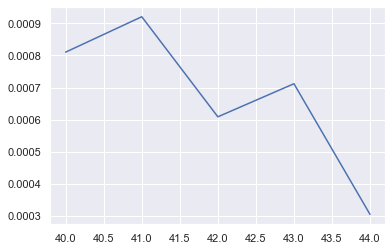

In [79]:
plt.plot(x,z)

In [80]:
svd = TruncatedSVD(n_components=43)
svd.fit(R)
sum(svd.explained_variance_ratio_)
# TRY GET 95

0.9515205944959535

In [81]:
all_user_predicted_ratings = svd.inverse_transform(svd.transform(R))

Let us visualize what we are roughly doing in 2D/2 components
The below image only generalises to 2 dimensions. Imagine each latent feature is 1 dimension. We are trying to find points that are close to each other within the different dimensions
<a class="anchor" id="3.1.3.1"></a>

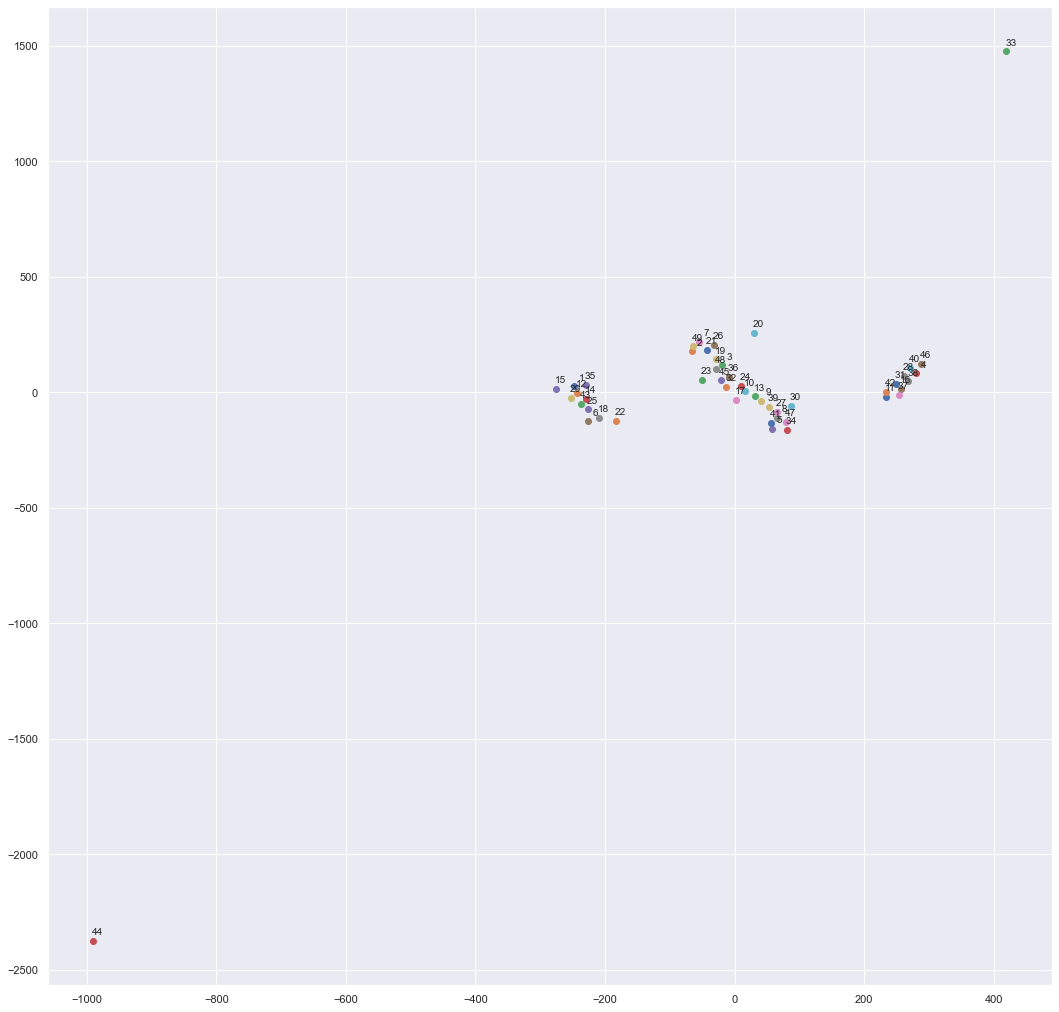

In [82]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=5, n_components=2, init="pca", n_iter=2000)
plot_only = 50
coords = tsne.fit_transform(all_user_predicted_ratings[:plot_only, :])

plt.figure(figsize=(18, 18))
labels = [i for i in range(1, 50)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")

plt.show()

In [83]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating_table.index, index=rating_table.columns)

In [84]:
# Subtracting Users Mean
average = list(preds_df.mean(axis=1))
for i in range(len(preds_df.index)):
    preds_df.iloc[i] = preds_df.iloc[i] - average[i]

<a class="anchor" id="3.1.3.2"></a>
### First Movie Recommendation
We will be using sklearn's `NearestNeighbours` to obtain the nearest point to our user via comparing Euclidean distance

In [85]:
movie_features_df_matrix = preds_df

# Once again we will be using cosine similarity
model_knn = NearestNeighbors(metric ='euclidean', algorithm ='auto')
model_knn.fit(movie_features_df_matrix)

# Query index picks a random movie among the 1281 entries of movies
query_index = 1280
# Choose the 6 nearest neighbours. Reshape is because we receive a Series
distance, indices = model_knn.kneighbors(preds_df.iloc[query_index,:].values.reshape(1, -1)
                                       , n_neighbors=4)

top3_users = []
for i in range(0, 4):
    if i == 0:
        print("Recommendation for {0}:\n".format(preds_df.index[query_index]))
    else:
        top3_users.append(preds_df.index[indices.flatten()[i]])
        print("{0}: {1} with distance of {2}:".format(i, preds_df.index[indices.flatten()[i]],distance.flatten()[i]))

Recommendation for 1281:

1: 758 with distance of 0.30319389263876434:
2: 991 with distance of 0.342795401446829:
3: 763 with distance of 0.3696167558266902:


In [86]:
myuserfavourites = sorted(enumerate(preds_df.iloc[1280]), reverse = True, key = lambda x: x[1])
print("Based on the movies you rated, some movies that you would like are:")
i = 0
count = 1
while count < 11:
    if rating_table.index[myuserfavourites[i][0]] in myrated:
        i+=1
    else:
        print(count,":",rating_table.index[myuserfavourites[i][0]])
        count+=1
        i+=1

Based on the movies you rated, some movies that you would like are:
1 : To Sir, with Love
2 : Close Encounters of the Third Kind
3 : WarGames
4 : The Post
5 : The Indian in the Cupboard
6 : Bite the Bullet
7 : Duck, You Sucker
8 : Your Son
9 : Felon
10 : Burning


In [87]:
top3_users
similar_users_average = (preds_df.loc[top3_users[0]] + preds_df.loc[top3_users[1]] + preds_df.loc[top3_users[1]])/3
similarusersfavourites = sorted(enumerate(similar_users_average), reverse = True, key = lambda x: x[1])
print("Based on the movies you rated, some movies poeple similar to you enjoy are:") 
i = 0
count = 1
while count < 11:
    if rating_table.index[similarusersfavourites[i][0]] in myrated:
        i+=1
    else:
        print(count,":",rating_table.index[similarusersfavourites[i][0]])
        count+=1
        i+=1

Based on the movies you rated, some movies poeple similar to you enjoy are:
1 : To Sir, with Love
2 : WarGames
3 : Bite the Bullet
4 : Close Encounters of the Third Kind
5 : The Indian in the Cupboard
6 : The Post
7 : Duck, You Sucker
8 : Your Son
9 : Felon
10 : Burning


What about recommending <b>Movie-Movie?</b> Let us try to recommend similar movies to the users list top movie and similarusers list top movie

In [88]:
title = [] # For Collecting our Top Movies
movie_features_df_matrix = csr_matrix(preds_df)

# Once again we will be using cosine similarity
model_knn = NearestNeighbors(metric ='euclidean', algorithm ='auto')
model_knn.fit(movie_features_df_matrix.transpose())

'''# Query index picks a random movie among the 1280 entries of movies
query_index = similarusersfavourites[0][0]
# Choose the 6 nearest neighbours. Reshape is because we receive a Series
distance, indices = model_knn.kneighbors(preds_df.transpose().iloc[query_index,:].values.reshape(1, -1)
                                       , n_neighbors=4)
'''

if myuserfavourites[0][0] == similarusersfavourites[0][0]:
    next = 1
else:
    next = 0

for i in [myuserfavourites[0][0],similarusersfavourites[next][0]]:
    query_index = i

    distance, indices = model_knn.kneighbors(preds_df.transpose().iloc[query_index,:].values.reshape(1, -1)
                                       , n_neighbors=4)
    top3_users = []
    for i in range(0, 4):
        if i == 0:
            print("\033[1mRecommendation for {0}:\033[0m\n ".format(preds_df.transpose().index[query_index]))
        else:
            if i == 1:
                title.append(preds_df.transpose().index[indices.flatten()[i]])
            top3_users.append(preds_df.transpose().index[indices.flatten()[i]])
            print("{0}: {1} with distance of {2}:\n".format(i, preds_df.transpose().index[indices.flatten()[i]],distance.flatten()[i]))

Recommendation for To Sir, with Love:
 
1: The Indian in the Cupboard with distance of 0.33761367403269155:

2: WarGames with distance of 0.33875394492779787:

3: Close Encounters of the Third Kind with distance of 0.3391817722780772:

Recommendation for WarGames:
 
1: The Indian in the Cupboard with distance of 0.043082969682522995:

2: The Post with distance of 0.05053305730697719:

3: Duck, You Sucker with distance of 0.08526447530043893:



<a class="anchor" id="3.1.4"></a>
### Alternating Least Squares Method 
However we also noted another method called ALS which seemed to perform slightly better in results. Let us take a look at it

In [89]:
import scipy
import implicit
import mkl
mkl.set_num_threads(2)
implicit.als.AlternatingLeastSquares

item_user_data = scipy.sparse.csr_matrix(rating_table2.values)
model = implicit.als.AlternatingLeastSquares(factors=700, regularization=0.5)
model.fit(item_user_data)

user_items = item_user_data.T.tocsr()
recommendations = model.recommend(1280, user_items)
related = model.similar_items(recommendations[0][0])

print("\033[1mMovies recommended to us:\033[0m")
title.append(rating_table2.index[recommendations[0][0]])
for i in recommendations[0:5]:
    print(rating_table2.index[i[0]])

print("\n\033[1mSimilar movies to {}\033[0m".format(rating_table2.index[recommendations[0][0]]))
for i in related[0:6]:
    if rating_table2.index[i[0]] == rating_table2.index[recommendations[0][0]]:
        continue
    print(rating_table2.index[i[0]])

  0%|          | 0/15 [00:00<?, ?it/s]

Movies recommended to us:
Child's Play 2
Another Earth
The Queen
Summer Rental
To Be or Not to Be

Similar movies to Child's Play 2
Wishmaster
Another Earth
Ong Bak 2
16 Blocks
The Hunger Games: Mockingjay - Part 1


Let us extract the top few movies from all these recommendation and actually try to apply them to <b>our business case</b> of recommending a Golden Village Movie

In [90]:
title.append(preds_df.transpose().index[myuserfavourites[0][0]])
title.append(preds_df.transpose().index[similarusersfavourites[0][0]])
stage_2_final = merged_data.loc[merged_data['Title'].isin(title)]

[Back to Content Page](#0.0)

### Extra Movie Datasets<a class="anchor" id="4.1"></a>

But first, let us first import and clean our Golden Village dataset and Disney Plus dataset for further recommendation.

<a class="anchor" id="4.1.1"></a>
### Golden Village Dataset

For this section, we will do some data handling and cleaning of the Golden Village dataset which our group directly extracted from GV website. `gv` will store our dataset.

In [91]:
# Importing the Golden Village dataset and filling nan values
gv = pd.read_csv('GVMovie_new.csv')
gv['Subtitle'] = gv['Subtitle'].fillna('None')
gv['Cast'] = gv['Cast'].fillna('None')
gv['runtime'] = gv['runtime'].fillna(0)
gv['Index'] = gv.index
gv = gv.drop(columns = ['Index','Language'])
print(gv.shape)
gv.head(3)

(49, 9)


Title                     Genres  \
0                        The Marksman           Action/ Thriller   
1  The Diam Diam Era Two 我们的故事之沉默的年代2              Drama/ Comedy   
2                         Tom & Jerry  Animation/ Comedy/ Family   

           Subtitle Date of Release  runtime  \
0           Chinese      2021-02-25    107.0   
1  English, Chinese      2021-02-11     91.0   
2           Chinese      2021-02-11    101.0   

                                                Cast       Director  \
0  Liam Neeson, Katheryn Winnick, Teresa Ruiz, Ju...  Robert Lorenz   
1  Mark Lee 李国煌, Richie Koh 许瑞奇, Danny Lee 李博 翔, ...   Jack Neo 梁志强   
2  Chloe Grace Moretz, Michael Peña, Colin Jost, ...      Tim Story   

  Distributor                                           Overview  
0         GVP  Hardened Arizona rancher Jim Hanson (Liam Nees...  
1         GVP  The story continues with Ah Kun, Osman and Sha...  
2          WB  One of the most beloved rivalries in history i...

In [92]:
gv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            49 non-null     object 
 1   Genres           48 non-null     object 
 2   Subtitle         49 non-null     object 
 3   Date of Release  49 non-null     object 
 4   runtime          49 non-null     float64
 5   Cast             49 non-null     object 
 6   Director         49 non-null     object 
 7   Distributor      48 non-null     object 
 8   Overview         49 non-null     object 
dtypes: float64(1), object(8)
memory usage: 3.6+ KB


After cleaning and filling in the `NULL` value, here, we have 51 movies which are either now showing or coming soon in Golden Village Cinema. We will use this dataset to implement recommendation later.

<a class="anchor" id="5.2.1"></a>
## One line code to recommend GV movies using TF-IDF and  cosine similarity

In [93]:
# Importing the Golden Village dataset and handle & fill in nan values
gv = pd.read_csv('GVMovie_new.csv')
gv['Subtitle'] = gv['Subtitle'].fillna('None')
gv['Cast'] = gv['Cast'].fillna('None')
gv['runtime'] = gv['runtime'].fillna(0)
gv['Index'] = gv.index
gv = gv.drop(columns = ['Index','Language'])


# Merge the GV dataset with the stage_2_final dataframe
stage_3_initial = stage_2_final[['Title', 'Genres','Available Languages','Year',
                                 'runtime','Cast','Production Company','Overview','Director']]
stage_3_initial = stage_3_initial.rename(columns = {'Available Languages':'Subtitle',
                                                    'Production Company':'Distributor',
                                                    'Year': 'Date of Release'})


# Merge tmdb movies into GV dataset
stage_3_merged = pd.concat([gv, stage_3_initial]).reset_index().drop(columns='index')


# Function to merge relevant columns
def merging_features(data):
    features = []
    for i in range(0, data.shape[0]):
        features.append(str(data['Genres'][i])+ " " + str(data['Cast'][i])+ " " +
                        str(data['Director'][i])+ " " + str(data["Overview"][i])+ " " +
                        str(data['Distributor'][i])+ " " + str(data['Date of Release'][i])+ " " +
                        str(data['Title'][i]))
    return features


# Apply on the dataframe stage_3_merged
stage_3_merged['Combined'] = merging_features(stage_3_merged)


# Import tf-idf function
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df = 3, max_features=None,
        strip_accents= 'unicode',analyzer='word',
        token_pattern = r'\w{1,}',
        ngram_range=(1,3),
        stop_words = 'english')
#stop_words = 'english', removes , . '' ! and words like this, is,she,is,that which are very repetitive


# Implement tf-idf on the combined column
from sklearn.metrics.pairwise import sigmoid_kernel

tfv_matrix = tfv.fit_transform(stage_3_merged['Combined'])
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)


# Apply cosine similarity on the tfv_matrix built
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfv_matrix)

# Make it a dataframe
sim = pd.DataFrame(cosine_sim)


# Locate the cosine similarity of the tmdb_movie
df = pd.DataFrame(sim.loc[:len(sim) - len(stage_2_final)-2,len(sim) - len(stage_2_final):])
df.columns = [stage_3_merged['Title'].loc[len(sim) - len(stage_2_final):]]

# Calculate average similarity
df['Average'] = df.sum(axis = 1)/ len(df.columns)
df = df[['Average']]
df = df.sort_values(ascending = False, by = df.columns[0])


import datetime
# do recommendation based on the sorted average cosine similarity of the movies
top5 = []
top5 = df[['Average']].iloc[0:5]
top5 = df.index.tolist()

# Print these things out
count = 1
print("Movies in Golden Village we recommend for you:")
for i in range(0,5):
    
    # Determine if the movie is out or not
    Y = int(stage_3_merged.iloc[top5[i]]['Date of Release'][:4])
    M = int(stage_3_merged.iloc[top5[i]]['Date of Release'][5:7])
    D = int(stage_3_merged.iloc[top5[i]]['Date of Release'][8:])
    Date = stage_3_merged.iloc[top5[i]]['Date of Release']
    
    today = datetime.date.today()
    someday = datetime.date(Y, M, D)
    diff = someday - today
    
    if(diff.days <= 0):
        print(count,': Now showing in cinema!' , stage_3_merged.iloc[top5[i]]['Title'])
    else:
        print(count,':',"Coming soon in", Date, stage_3_merged.iloc[top5[i]]['Title'])
    
    count+=1

Movies in Golden Village we recommend for you:
1 : Coming soon in 2021-06-10 Peter Rabbit 2: The Runaway
2 : Coming soon in 2021-07-29 The Suicide Squad
3 : Now showing in cinema! Casino Royale
4 : Now showing in cinema! The Conjuring 3: The Devil Made Me Do It
5 : Coming soon in 2021-05-27 Fast & Furious 9


<a class="anchor" id="5.2.2"></a>
## One line code on recommending based on our own defined function

In [147]:
# The tmdb movies we are using to recommend user the Golden Village movies
tmdb_copy = stage_3_initial.copy()

#####
# Extract user's rating column
ratess = preds_df.transpose()
ratess = ratess[[len(ratess.columns)]].reset_index()
rating_new = ratess.rename(columns = {1281:'Ratings'})

# Find the movie's user rating and merge it with our tmdb dataset
tmdb_copy['tmdb_rating'] = 0

for i in range(len(tmdb_copy)):
    rating = (rating_new.loc[rating_new['Title'] == tmdb_copy['Title'].iloc[i]]).iloc[0]['Ratings']
    tmdb_copy['tmdb_rating'].iloc[i] = rating

# Import gv dataset
gv_movie = pd.read_csv("GVMovie_new.csv")
gv_movie = gv_movie.drop(columns = 'Language')
gv_movie.head()

# Preprocess the Overview 
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# function to remove punctuation and stopwords from Overview
def filter_(my_str):
    stop_words = set(stopwords.words('english'))
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    
    # make no_punct into a list
    string = no_punct.split(' ')
    
    # remove STOPWORDS from string
    filtered = [w for w in string if not w in stop_words]
    
    return filtered

# Define our own similarity function, and apply it
def similarity(GV_data, TMDB_data):
    Average = [] # List to store all average of GV movies Vs tmdb movies
    
    for j in range(len(GV_data)): # Iterate through GV movies
        
        weighted_feature = [] # List to store all the features' score before adding them up and calculate average
        
        for i in range(len(TMDB_data)): # Around 3-4
            
            movie_count = [] # List to store that movie's scores with every features
            
            
            
            # 1 - Genre Score Counting
            
            # Step 1 - Make all the Genres in each dataset into two distinct list
            Genre_tmdb = str(TMDB_data['Genres'].iloc[i]).split(", ")
            Genre_tmdb.remove('')
            Genre_GV = str(GV_data['Genres'].iloc[j]).split("/ ")

            # Step 2 - Find the intersected elements, make it into a list
            G_intersect = list(set.intersection(set(Genre_tmdb), set(Genre_GV)))
            
            # We simply found that the len(intersect) will be the number of overlapped elements
            # which basically is the overlapped count we are trying to find
            
            Genre_score = len(G_intersect) * 0.35 # Step 3 - multiply by our weighted importance
            movie_count.append(Genre_score) # Step 4 - Append Genre_score into list
            
            # Next, we will perform the same thing on the rest of the features            
            
            
            
            # 2 - Actor Score Counting
            
            Actor_tmdb = (tmdb_copy['Cast'].iloc[i]).split(", ")
            Actor_tmdb.remove('')
            
            Actor_GV = str(gv_movie['Cast'].iloc[j]).split(", ")
            
            A_intersect = list(set.intersection(set(Actor_tmdb), set(Actor_GV)))
            
            Actor_score = len(A_intersect) * 0.25
            movie_count.append(Actor_score)
            
            
            
            # 3 - Director Score Counting
            
            # Handling tmdb_copy dataset
            Director_tmdb = (tmdb_copy['Director'].iloc[0]).split(", ")
            Director_tmdb.remove('')
            
            Director_GV = (gv_movie['Director'].iloc[0]).split(", ")

            D_intersect = list(set.intersection(set(Director_tmdb), set(Director_GV)))
            
            Director_score = len(D_intersect) * 0.15
            movie_count.append(Director_score)
            
            
            
            # 4 - Overview
            Overview_tmdb = filter_(tmdb_copy['Overview'].iloc[i])
            Overview_GV = filter_(gv_movie['Overview'].iloc[j])

            O_intersect = list(set.intersection(set(Overview_GV), set(Overview_tmdb)))
            
            Overview_score = len(O_intersect) * 0.125
            movie_count.append(Overview_score)
            
            
            
            # 5 - Distributor
            Distributor_tmdb = (tmdb_copy['Distributor'].iloc[0]).split(", ")
            Distributor_tmdb.remove('')
            
            Distributor_GV = (gv_movie['Distributor'].iloc[0]).split(", ")
            
            DD_intersect = list(set.intersection(set(Distributor_tmdb), set(Distributor_GV)))
            
            Distributor_score = len(DD_intersect) * 0.075
            movie_count.append(Distributor_score)
                        
            
            
            # 6 - Subtitle
            
            Subtitle_tmdb = (tmdb_copy['Subtitle'].iloc[0]).split(", ")
            Subtitle_tmdb.remove('')
            
            Subtitle_GV = (gv_movie['Subtitle'].iloc[0]).split(", ")
            
            S_intersect = list(set.intersection(set(Subtitle_tmdb), set(Subtitle_GV)))
            
            Subtitle_score = len(S_intersect) * 0.05
            movie_count.append(Subtitle_score)
            
            
            
            # After we get all the features weighted score, we sum it up
            sim = sum(movie_count)
            
            # Before moving on to next tmdb movie, multiply sim with predicted user rating on the tmdb movie
            weighted = TMDB_data['tmdb_rating'].iloc[i] * sim
            
            # Then, we append it into a new list which store all the 4 movies weighted score
            weighted_feature.append(weighted)
            
            
        # After we get all the sim score of the GV movie against all the 4 tmdb movies,
        # We divide and find the average weighted sim score for that movie
        average_sim = sum(weighted_feature) / len(weighted_feature)
        
        # Append the average weighted sim so that later we can merge it into the gv_movie dataframe
        Average.append(average_sim)
    
    return Average

# Implement the sim function
Sim_score = similarity(gv_movie, tmdb_copy)

# Append the similarity score to a new column
gv_movie['Similarity'] = Sim_score

# Here, we can actually print out the top 5 recommended movies by simply sorting the values on 'Similarity'
# Which is simply to say, can just recommend by the code below

gv_movie.sort_values(by = 'Similarity', ascending = False).head()

# But we wanted something more than that

# Lets print out the above top 5 in a prettier way
# Sort the similarity score and found the top 5 recommended movies for GV
top5 = []
top5.append((gv_movie.sort_values(by = 'Similarity', ascending = False).head()).index)
top5


# Print these things out
count = 1
import datetime
print("Movies in Golden Village we recommend for you:")
for i in range(0,5):
    
    # Determine if the movie is out or not
    Y = int(gv_movie.iloc[top5[0][i]]['Date of Release'][:4])
    M = int(gv_movie.iloc[top5[0][i]]['Date of Release'][5:7])
    D = int(gv_movie.iloc[top5[0][i]]['Date of Release'][8:])
    Date = gv_movie.iloc[top5[0][i]]['Date of Release']
    
    today = datetime.date.today()
    someday = datetime.date(Y, M, D)
    diff = someday - today
    
    if(diff.days <= 0):
        print(count,': Now showing in cinema!', gv_movie.iloc[top5[0][i]]['Title'])
    else:
        print(count,':',"Coming soon in", Date, gv_movie.iloc[top5[0][i]]['Title'])
    
    count+=1


Movies in Golden Village we recommend for you:
1 : Coming soon in 2021-06-03 Disney's Cruella
2 : Coming soon in 2021-04-29 Josee, The Tiger And The Fish
3 : Now showing in cinema! Disney’s Raya And The Last Dragon
4 : Now showing in cinema! Minari
5 : Now showing in cinema! Nomadland


<a class="anchor" id="5.2.3"></a>
## One line code on finding nearest cinema and timings

In [148]:
# Let's write a function and print the above information in a better and cleaner way
def print_reco(dataframe):
    from datetime import datetime
    
    print('You might be interested in these movies showing in', dataframe.GV.iloc[0], 'Golden Village cinema:')
    print('The nearest MRT station is: ', dataframe.STN_NAME.iloc[0],'\n')
    count = 1

    for i in range(len(dataframe)):
        print(count,': ',dataframe['Title'].iloc[i])
        print('The movies\' timing are listed below:')
    
        for j in range(len(dataframe['Datetime'].iloc[i])):
        
            datetimeFormat = '%d-%m-%Y %H:%M:%S'
            now = datetime.now()
            date1 = now.strftime(datetimeFormat)
            date2 = dataframe['Datetime'].iloc[i][j]
            diff = datetime.strptime(date2, datetimeFormat)- datetime.strptime(date1, datetimeFormat)
            # Streaming time - Today's time
                   
            if(diff.days == 0): # Print out all the future timings
                print(dataframe['Datetime'].iloc[i][j])
    
        print()
        count += 1

# Let's start out sorting by first filtering out the now showing AND recommended movies for the user
sorted_gv = gv_movie.sort_values(by = 'Similarity', ascending = False)

now_showing = []

# Print these things out
count = 1
print("Movies currently showing in Golden Village we recommend for you:")

import datetime
for i in range(15):
    # Determine if the movie is out or not
    Y = int(sorted_gv.iloc[i]['Date of Release'][:4])
    M = int(sorted_gv.iloc[i]['Date of Release'][5:7])
    D = int(sorted_gv.iloc[i]['Date of Release'][8:])
    Date = sorted_gv.iloc[i]['Date of Release']
    
    today = datetime.date.today()
    someday = datetime.date(Y, M, D)
    diff = someday - today
    
    if((diff.days <= 0) & (count<6)):
        print(count, ': ', sorted_gv.iloc[i]['Title'])
        now_showing.append(sorted_gv.iloc[i]['Title'])
        count += 1
    elif(count > 10):
        break
    else:
        continue

        
mrt_lrt = pd.read_csv("mrtsg.csv")

mrt = mrt_lrt[~mrt_lrt.STN_NAME.str.contains("LRT")]
mrt = mrt.reset_index()
mrt = mrt.drop(columns = ['index','STN_NO','OBJECTID'])
mrt = mrt.drop_duplicates(subset = ['STN_NAME','COLOR'], keep = 'first')


# We first ask user to input the region he/she is in
print("Which MRT station is the nearest to you now?\n")

place = str(input("Please enter a place:"))
place = place.upper()
print('Oh I see, you are at somewhere near', place, 'now!\n')


timing = pd.read_csv("timing.csv")

# Let's first handle the datetime, we will make DATE(D/M) and TIME into a single column
timing['Datetime'] = 0
for i in range(len(timing)):
    value = ""
    value += timing['DATE(D/M)'].loc[i]
    value += ' '
    value += str(timing['TIME'].loc[i])[:-2]
    value += ':'
    value += str(timing['TIME'].loc[i])[-2:]
    value += ':00'
        
    timing['Datetime'].loc[i] = value
    
timing = timing.drop(columns = ['DATE(D/M)', 'TIME'])


# To ease the calculation of the nearest GV cinema
# First, we merge the Longitude and Latitude according to each mrt station into this dataframe
timing = pd.merge(timing, pd.DataFrame(mrt[['STN_NAME','Latitude','Longitude','COLOR']]), on = 'STN_NAME')

# Next, we try to merge all the show times of a same movie in a same cinema into a list
timing = timing.groupby(['Title','STN_NAME','GV', 'Latitude','Longitude','COLOR'])['Datetime'].apply(list).reset_index()

timing = timing.drop_duplicates(subset = timing.columns[:-1] , keep = 'first')


# Then, we filter out the recommended movies for the user
recommended_movie = pd.DataFrame(columns = timing.columns)

for i in range(len(now_showing)):
    recommended_movie = recommended_movie.append(timing[timing.Title.str.contains(now_showing[i]) == True])
    

# Let's try and compute the nearest 2 stops from the given place
# Here, we will use a formula called Harvesine formula to compute the distance between chosen mrt and other mrt

import math
R = 6373.0 # Radius of Earth

# Before we do anything, let's create a 'distance' column to store the computed distance
recommended_movie['Distance'] = 0

# First, we extract longitude and latitude of the place where our user is 
lat1 = math.radians(mrt[mrt['STN_NAME'].str.contains(place)]['Latitude'].iloc[0])
lon1 = math.radians(mrt[mrt['STN_NAME'].str.contains(place)]['Longitude'].iloc[0])

# Next, we loop through the whole dataset to compute the distance between given mrt and other mrt
for i in range(len(recommended_movie)):
    lat2 = math.radians(recommended_movie['Latitude'].iloc[i])
    lon2 = math.radians(recommended_movie['Longitude'].iloc[i])
    
    # Everything's set, let's compute the distance of the two station!
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    recommended_movie['Distance'].iloc[i] = distance


sorted_reco = recommended_movie.sort_values(by = 'Distance', ascending = True)


# Let's find out the user's nearest MRT line color, and make it into a list
color = []
for i in range(len(mrt[mrt['STN_NAME'].str.contains(place)])):
    color.append(mrt[mrt['STN_NAME'].str.contains(place)]['COLOR'].iloc[i])
    

# Then, we filtered out the GV cinema on the same color line, and sort the distance
current_line_gv = sorted_reco[sorted_reco['COLOR'] == color[0]]
for i in range(len(color)-1):
    current_line_gv = current_line_gv.append(sorted_reco[sorted_reco['COLOR'] == color[i+1]])
    
    
# Sort the current_line_gv to avoid wrong station
sort = current_line_gv.sort_values(by = 'Distance')
    
    
# Next, we try to extract the first 2 nearest station which are on the same line
same_line = []
#timing.drop_duplicates(subset = timing.columns[:-1] , keep = 'first')
two_station = sort[['STN_NAME']].drop_duplicates(keep = 'first').iloc[:2]

if(len(two_station) < 2): # Only 1 station
    same_line.append(two_station['STN_NAME'].iloc[0])
    
    final_suggestion1 = pd.DataFrame(columns = current_line_gv.columns)
    final_suggestion1 = final_suggestion1.append(current_line_gv[current_line_gv['STN_NAME'] == same_line[0]])
    
    print_reco(final_suggestion1)
    
else:
    for i in range(2):
        same_line.append(two_station['STN_NAME'].iloc[i])
        
    # Lastly, we will proceed to filter out the GV cinemas near these mrt and print it to the users
    final_suggestion1 = pd.DataFrame(columns = current_line_gv.columns)
    final_suggestion1 = final_suggestion1.drop_duplicates(keep = 'first')
    final_suggestion1 = final_suggestion1.append(current_line_gv[current_line_gv['STN_NAME'] == same_line[0]])


    final_suggestion2 = pd.DataFrame(columns = current_line_gv.columns)
    final_suggestion2 = final_suggestion2.append(current_line_gv[current_line_gv['STN_NAME'] == same_line[1]])
    
    print_reco(final_suggestion1)
    print_reco(final_suggestion2)

Movies currently showing in Golden Village we recommend for you:
1 :  Disney’s Raya And The Last Dragon
2 :  Minari
3 :  Nomadland
4 :  Seobok
5 :  Karnan
Which MRT station is the nearest to you now?

Please enter a place:yishun
Oh I see, you are at somewhere near YISHUN now!

You might be interested in these movies showing in North Point Golden Village cinema:
The nearest MRT station is:  YISHUN MRT STATION 

1 :  Minari
The movies' timing are listed below:
15-4-2021 15:50:00

2 :  Seobok
The movies' timing are listed below:
15-4-2021 13:50:00
15-4-2021 16:25:00
15-4-2021 19:00:00
15-4-2021 21:35:00

3 :  Disney’s Raya And The Last Dragon
The movies' timing are listed below:
15-4-2021 16:15:00
15-4-2021 18:50:00

4 :  Karnan
The movies' timing are listed below:
15-4-2021 13:20:00
15-4-2021 15:00:00
15-4-2021 18:15:00
15-4-2021 21:30:00

You might be interested in these movies showing in Bishan Golden Village cinema:
The nearest MRT station is:  BISHAN MRT STATION 

1 :  Disney’s Raya 

The codes below is already included inside the one line codes above. However, the codes below will include the markdow as well, so we will still run them to improve the readability.

### Application on our Business Case

<a class="anchor" id="5.1"></a>
### Golden Village Movie Recommender

Here, by taking the movies we got while recommending movies to user based on the imdb dataset, we use these movies from `stage_2_final` to further recommend Golden Village movies to our user.

In [103]:
stage_2_final

movieId  imdbId       id                        Genres  \
48         53  110299  49133.0  Adventure, Family, Fantasy,    
984      1285   97493   2640.0               Drama, Horror,    
7812    92494  439553  13976.0                       Drama,    

                                               Overview  popularity  \
48    A nine-year-old boy gets a plastic Indian and ...   10.673296   
984   Chuckie's back as the doll possessed by the so...   14.310479   
7812  Idealistic engineer-trainee and his experience...    8.138554   

                                     Production Company  \
48    Paramount Pictures, Columbia Pictures Corporat...   
984                                Universal Pictures,    
7812                     Columbia British Productions,    

                         Country  Year  runtime Available Languages  \
48    United States of America,   1995     96.0           English,    
984   United States of America,   1990     84.0   English, Türkçe,    
7812            United Kingdom,   1967    105.0           English,    

                           Title  Average_rating  \
48    The Indian in the Cupboard        2.828125   
984               Child's Play 2        2.000000   
7812           To Sir, with Love        3.562500   

                                                   Cast  \
48    Hal Scardino, Litefoot, Lindsay Crouse, Richar...   
984   Alex Vincent, Jenny Agutter, Gerrit Graham, Ch...   
7812  Sidney Poitier, Suzy Kendall, Christian Robert...   

                        Collection         Director  
48                             NaN       Frank Oz,   
984        Child's Play Collection     John Lafia,   
7812  To Sir, with Love Collection  James Clavell,

In [104]:
gv.head()

Title                     Genres  \
0                               The Marksman           Action/ Thriller   
1         The Diam Diam Era Two 我们的故事之沉默的年代2              Drama/ Comedy   
2                                Tom & Jerry  Animation/ Comedy/ Family   
3  Doraemon The Movie: Nobita's New Dinosaur                        NaN   
4                                     Minari                      Drama   

           Subtitle Date of Release  runtime  \
0           Chinese      2021-02-25    107.0   
1  English, Chinese      2021-02-11     91.0   
2           Chinese      2021-02-11    101.0   
3  English, Chinese      2021-02-25    110.0   
4  English, Chinese      2021-03-11    115.0   

                                                Cast         Director  \
0  Liam Neeson, Katheryn Winnick, Teresa Ruiz, Ju...    Robert Lorenz   
1  Mark Lee 李国煌, Richie Koh 许瑞奇, Danny Lee 李博 翔, ...     Jack Neo 梁志强   
2  Chloe Grace Moretz, Michael Peña, Colin Jost, ...        Tim Story   
3  Megumi Oohara, Wasabi Mizuta, Yumi Kakazu, Sub...     Kazuaki Imai   
4  Steven Yeun, Yeri Han, Alan Kim, Noel Kate Cho...  Lee Isaac Chung   

  Distributor                                           Overview  
0         GVP  Hardened Arizona rancher Jim Hanson (Liam Nees...  
1         GVP  The story continues with Ah Kun, Osman and Sha...  
2          WB  One of the most beloved rivalries in history i...  
3        Odex  Nobita hatches two new dinosaurs, named Kyu an...  
4         GVP  A tender and sweeping story about what roots u...

In [105]:
# Merge the GV dataset with the stage_2_final dataframe
stage_3_initial = stage_2_final[['Title', 'Genres','Available Languages','Year',
                                 'runtime','Cast','Production Company','Overview','Director']]
stage_3_initial = stage_3_initial.rename(columns = {'Available Languages':'Subtitle',
                                                    'Production Company':'Distributor',
                                                    'Year': 'Date of Release'})
stage_3_initial.dtypes

Title               object
Genres              object
Subtitle            object
Date of Release      int64
runtime            float64
Cast                object
Distributor         object
Overview            object
Director            object
dtype: object

In [106]:
stage_3_merged = pd.concat([gv, stage_3_initial]).reset_index().drop(columns='index')
print(stage_3_merged.shape)
stage_3_merged.tail()

(52, 9)


Title                        Genres  \
47  Josee, The Tiger And The Fish                Drama/ Romance   
48                    Great White              Horror/ Thriller   
49     The Indian in the Cupboard  Adventure, Family, Fantasy,    
50                 Child's Play 2               Drama, Horror,    
51              To Sir, with Love                       Drama,    

             Subtitle Date of Release  runtime  \
47   English, Chinese      2021-04-29     98.0   
48            Chinese      2021-05-13     91.0   
49          English,             1995     96.0   
50  English, Türkçe,             1990     84.0   
51          English,             1967    105.0   

                                                 Cast         Director  \
47                     Taishi Nakagawa, Kaya Kiyohara    Kotaro Tamura   
48  Katrina Bowden, Aaron Jakubenko, Kimie Tsukako...    Martin Wilson   
49  Hal Scardino, Litefoot, Lindsay Crouse, Richar...       Frank Oz,    
50  Alex Vincent, Jenny Agutter, Gerrit Graham, Ch...     John Lafia,    
51  Sidney Poitier, Suzy Kendall, Christian Robert...  James Clavell,    

                                          Distributor  \
47                                                GVP   
48                                                GVP   
49  Paramount Pictures, Columbia Pictures Corporat...   
50                               Universal Pictures,    
51                     Columbia British Productions,    

                                             Overview  
47  Josee is a girl who loves painting and reading...  
48  A blissful tourist trip quickly turns into a n...  
49  A nine-year-old boy gets a plastic Indian and ...  
50  Chuckie's back as the doll possessed by the so...  
51  Idealistic engineer-trainee and his experience...

In [107]:
stage_3_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            52 non-null     object 
 1   Genres           51 non-null     object 
 2   Subtitle         52 non-null     object 
 3   Date of Release  52 non-null     object 
 4   runtime          52 non-null     float64
 5   Cast             52 non-null     object 
 6   Director         52 non-null     object 
 7   Distributor      51 non-null     object 
 8   Overview         52 non-null     object 
dtypes: float64(1), object(8)
memory usage: 3.8+ KB


In [108]:
# Function to merge relevant columns
def merging_features(data):
    features = []
    for i in range(0, data.shape[0]):
        features.append(str(data['Genres'][i])+ " " + str(data['Cast'][i])+ " " +
                        str(data['Director'][i])+ " " + str(data["Overview"][i])+ " " +
                        str(data['Distributor'][i])+ " " + str(data['Date of Release'][i])+ " " +
                        str(data['Title'][i]))
    return features

In [109]:
stage_3_merged['Combined'] = merging_features(stage_3_merged)
stage_3_merged.tail()

Title                        Genres  \
47  Josee, The Tiger And The Fish                Drama/ Romance   
48                    Great White              Horror/ Thriller   
49     The Indian in the Cupboard  Adventure, Family, Fantasy,    
50                 Child's Play 2               Drama, Horror,    
51              To Sir, with Love                       Drama,    

             Subtitle Date of Release  runtime  \
47   English, Chinese      2021-04-29     98.0   
48            Chinese      2021-05-13     91.0   
49          English,             1995     96.0   
50  English, Türkçe,             1990     84.0   
51          English,             1967    105.0   

                                                 Cast         Director  \
47                     Taishi Nakagawa, Kaya Kiyohara    Kotaro Tamura   
48  Katrina Bowden, Aaron Jakubenko, Kimie Tsukako...    Martin Wilson   
49  Hal Scardino, Litefoot, Lindsay Crouse, Richar...       Frank Oz,    
50  Alex Vincent, Jenny Agutter, Gerrit Graham, Ch...     John Lafia,    
51  Sidney Poitier, Suzy Kendall, Christian Robert...  James Clavell,    

                                          Distributor  \
47                                                GVP   
48                                                GVP   
49  Paramount Pictures, Columbia Pictures Corporat...   
50                               Universal Pictures,    
51                     Columbia British Productions,    

                                             Overview  \
47  Josee is a girl who loves painting and reading...   
48  A blissful tourist trip quickly turns into a n...   
49  A nine-year-old boy gets a plastic Indian and ...   
50  Chuckie's back as the doll possessed by the so...   
51  Idealistic engineer-trainee and his experience...   

                                             Combined  
47  Drama/ Romance Taishi Nakagawa, Kaya Kiyohara ...  
48  Horror/ Thriller Katrina Bowden, Aaron Jakuben...  
49  Adventure, Family, Fantasy,  Hal Scardino, Lit...  
50  Drama, Horror,  Alex Vincent, Jenny Agutter, G...  
51  Drama,  Sidney Poitier, Suzy Kendall, Christia...

<a class="anchor" id="5.1.1"></a>
### Implementing TF-IDF and Cosine Similarity

Let us perform TF-IDF Vectorizer on our 'Combined' column. 

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df = 3, max_features=None,
        strip_accents= 'unicode',analyzer='word',
        token_pattern = r'\w{1,}',
        ngram_range=(1,3),
        stop_words = 'english')
#stop_words = 'english', removes , . '' ! and words like this, is,she,is,that which are very repetitive

In [111]:
from sklearn.metrics.pairwise import sigmoid_kernel

tfv_matrix = tfv.fit_transform(stage_3_merged['Combined'])
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [112]:
# Apply cosine similarity on the tfv_matrix built
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfv_matrix)

# Make it a dataframe
sim = pd.DataFrame(cosine_sim)
sim.head()

0         1         2         3         4         5         6   \
0  1.000000  0.238243  0.152883  0.189478  0.276291  0.067243  0.064965   
1  0.238243  1.000000  0.278769  0.155267  0.411019  0.074485  0.042995   
2  0.152883  0.278769  1.000000  0.259805  0.206001  0.209229  0.090097   
3  0.189478  0.155267  0.259805  1.000000  0.147601  0.173434  0.079101   
4  0.276291  0.411019  0.206001  0.147601  1.000000  0.142941  0.167022   

         7         8         9   ...        42        43        44        45  \
0  0.098524  0.041740  0.054488  ...  0.068187  0.124989  0.046444  0.083385   
1  0.067192  0.078392  0.038140  ...  0.205986  0.197939  0.109060  0.078210   
2  0.111052  0.200517  0.046394  ...  0.025123  0.071759  0.076945  0.053717   
3  0.142446  0.046042  0.007592  ...  0.182265  0.113331  0.114534  0.008380   
4  0.166041  0.133507  0.116393  ...  0.110845  0.096012  0.047830  0.061985   

         46        47        48        49        50        51  
0  0.237958  0.092540  0.153954  0.200904  0.023463  0.053626  
1  0.068874  0.118843  0.065868  0.043023  0.093917  0.052065  
2  0.239857  0.034872  0.005131  0.088590  0.144000  0.074174  
3  0.259791  0.075418  0.120337  0.000000  0.107139  0.070671  
4  0.095550  0.124767  0.052203  0.127502  0.050270  0.031346  

[5 rows x 52 columns]

Here, we will extract the cosine similarity score for the 4 movies we used and take the average of them to further continue our Golden Village movies recommendation.

In [113]:
df = pd.DataFrame(sim.loc[:len(sim) - len(stage_2_final)-2,len(sim) - len(stage_2_final):])
df.columns = [stage_3_merged['Title'].loc[len(sim) - len(stage_2_final):]]
df.head()

Title The Indian in the Cupboard Child's Play 2 To Sir, with Love
0                       0.200904       0.023463          0.053626
1                       0.043023       0.093917          0.052065
2                       0.088590       0.144000          0.074174
3                       0.000000       0.107139          0.070671
4                       0.127502       0.050270          0.031346

In [114]:
df['Average'] = df.sum(axis = 1)/ len(df.columns)
df.head()

Title The Indian in the Cupboard Child's Play 2 To Sir, with Love   Average
0                       0.200904       0.023463          0.053626  0.092664
1                       0.043023       0.093917          0.052065  0.063002
2                       0.088590       0.144000          0.074174  0.102255
3                       0.000000       0.107139          0.070671  0.059270
4                       0.127502       0.050270          0.031346  0.069706

In [115]:
df = df[['Average']]
df = df.sort_values(ascending = False, by = df.columns[0])
df.head()

Title   Average
19     0.261275
38     0.168569
40     0.152538
18     0.147041
17     0.142429

Here, we get the **Top 5** movies to be recommended to our users based on the four movies we got from `stage_2_final`.

Next, let's print out what these movies are!

In [116]:
import datetime

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [117]:
# do recommendation based on average cosine similarity of the 2 movies

top5 = []
top5 = df[['Average']].iloc[0:5]
top5 = df.index.tolist()

# Print these things out
count = 1
print("Movies in " + color.BOLD + "Golden Village" + color.END + " we recommend for you:")
for i in range(0,5):
    
    # Determine if the movie is out or not
    Y = int(stage_3_merged.iloc[top5[i]]['Date of Release'][:4])
    M = int(stage_3_merged.iloc[top5[i]]['Date of Release'][5:7])
    D = int(stage_3_merged.iloc[top5[i]]['Date of Release'][8:])
    Date = stage_3_merged.iloc[top5[i]]['Date of Release']
    
    today = datetime.date.today()
    someday = datetime.date(Y, M, D)
    diff = someday - today
    
    if(diff.days <= 0):
        print(count,':',color.BOLD + "Now showing in cinema!" + color.END, stage_3_merged.iloc[top5[i]]['Title'])
    else:
        print(count,':',"Coming soon in", color.BOLD + Date + color.END, stage_3_merged.iloc[top5[i]]['Title'])
    
    count+=1

Movies in Golden Village we recommend for you:
1 : Coming soon in 2021-06-10 Peter Rabbit 2: The Runaway
2 : Coming soon in 2021-07-29 The Suicide Squad
3 : Now showing in cinema! Casino Royale
4 : Now showing in cinema! The Conjuring 3: The Devil Made Me Do It
5 : Coming soon in 2021-05-27 Fast & Furious 9


In [118]:
# just for checking
for i in range(0,5):
    print(stage_3_merged.iloc[top5[i]]['Title'], "-", 
          stage_3_merged.iloc[top5[i]]['Genres'])

Peter Rabbit 2: The Runaway - Animation
The Suicide Squad - Action/ Adventure
Casino Royale - Action/ Thriller

The Conjuring 3: The Devil Made Me Do It - Horror
Fast & Furious 9 - Action/ Adventure


Here, we ended our recommendation on **Golden Village movies**. As you can see, some of the movies are out, for the coming soon movies, you can still watch them after the stated dates above!

Next, we will move on to something we tried based on other consideration.

<a class="anchor" id="5.1.2"></a>

## Our own function - Average Weighted Similarity
### Create a new, subjective similarity measurement

Knowing that every single users have their own biases while picking the movies they wanted to watch, we still defined the importance of each features based on our own assumption.

We know that this way of recommendation might not be suitable on every single user, however, we could included it as a possibility of future improvement. For example, we can improve by first asking a user to rank his/ her importance/ priority on each features, and proceed to process our recommendation. We believe that this will enable us to appraoch a `personalised movie recommendation system`.

As such, we wanted to clarify that the orders of the features below is based on **own defined importance**. 

The feature list we took in consideration is as follow:

   1. Genres
   2. Cast
   3. Director
   4. Distributor
   5. Overview
   6. Subtitle

In [119]:
# The tmdb movies we are using to recommend user the Golden Village movies
tmdb_copy = stage_3_initial.copy()
tmdb_copy

Title                        Genres  \
48    The Indian in the Cupboard  Adventure, Family, Fantasy,    
984               Child's Play 2               Drama, Horror,    
7812           To Sir, with Love                       Drama,    

               Subtitle  Date of Release  runtime  \
48            English,              1995     96.0   
984   English, Türkçe,              1990     84.0   
7812          English,              1967    105.0   

                                                   Cast  \
48    Hal Scardino, Litefoot, Lindsay Crouse, Richar...   
984   Alex Vincent, Jenny Agutter, Gerrit Graham, Ch...   
7812  Sidney Poitier, Suzy Kendall, Christian Robert...   

                                            Distributor  \
48    Paramount Pictures, Columbia Pictures Corporat...   
984                                Universal Pictures,    
7812                     Columbia British Productions,    

                                               Overview         Director  
48    A nine-year-old boy gets a plastic Indian and ...       Frank Oz,   
984   Chuckie's back as the doll possessed by the so...     John Lafia,   
7812  Idealistic engineer-trainee and his experience...  James Clavell,

As we have perform **User Rating Prediction** before, now, we will make use of that rating to further proceed to calculate our weighted average similarity.

Thus, here, we will try to extract the user's rating and merge it into our tmdb dataset.

In [120]:
# Extract user's rating column
rating_new = rating_table[[1281]].reset_index()
rating_new = rating_new.rename(columns = {1281:'Ratings'})

# Find the movie's user rating and merge it with our tmdb dataset
tmdb_copy['tmdb_rating'] = 0

for i in range(len(tmdb_copy)):
    rating = (rating_new.loc[rating_new['Title'] == tmdb_copy['Title'].iloc[i]]).iloc[0]['Ratings']
    tmdb_copy['tmdb_rating'].iloc[i] = rating
    
tmdb_copy

Title                        Genres  \
48    The Indian in the Cupboard  Adventure, Family, Fantasy,    
984               Child's Play 2               Drama, Horror,    
7812           To Sir, with Love                       Drama,    

               Subtitle  Date of Release  runtime  \
48            English,              1995     96.0   
984   English, Türkçe,              1990     84.0   
7812          English,              1967    105.0   

                                                   Cast  \
48    Hal Scardino, Litefoot, Lindsay Crouse, Richar...   
984   Alex Vincent, Jenny Agutter, Gerrit Graham, Ch...   
7812  Sidney Poitier, Suzy Kendall, Christian Robert...   

                                            Distributor  \
48    Paramount Pictures, Columbia Pictures Corporat...   
984                                Universal Pictures,    
7812                     Columbia British Productions,    

                                               Overview         Director  \
48    A nine-year-old boy gets a plastic Indian and ...       Frank Oz,    
984   Chuckie's back as the doll possessed by the so...     John Lafia,    
7812  Idealistic engineer-trainee and his experience...  James Clavell,    

      tmdb_rating  
48       5.135636  
984      3.910146  
7812     5.135636

Let's extract again our GV dataset.

In [121]:
gv_movie = pd.read_csv("GVMovie_new.csv")
gv_movie = gv_movie.drop(columns = 'Language')
gv_movie.head()

Title                     Genres  \
0                               The Marksman           Action/ Thriller   
1         The Diam Diam Era Two 我们的故事之沉默的年代2              Drama/ Comedy   
2                                Tom & Jerry  Animation/ Comedy/ Family   
3  Doraemon The Movie: Nobita's New Dinosaur                        NaN   
4                                     Minari                      Drama   

           Subtitle Date of Release  runtime  \
0           Chinese      2021-02-25    107.0   
1  English, Chinese      2021-02-11     91.0   
2           Chinese      2021-02-11    101.0   
3  English, Chinese      2021-02-25    110.0   
4  English, Chinese      2021-03-11    115.0   

                                                Cast         Director  \
0  Liam Neeson, Katheryn Winnick, Teresa Ruiz, Ju...    Robert Lorenz   
1  Mark Lee 李国煌, Richie Koh 许瑞奇, Danny Lee 李博 翔, ...     Jack Neo 梁志强   
2  Chloe Grace Moretz, Michael Peña, Colin Jost, ...        Tim Story   
3  Megumi Oohara, Wasabi Mizuta, Yumi Kakazu, Sub...     Kazuaki Imai   
4  Steven Yeun, Yeri Han, Alan Kim, Noel Kate Cho...  Lee Isaac Chung   

  Distributor                                           Overview  
0         GVP  Hardened Arizona rancher Jim Hanson (Liam Nees...  
1         GVP  The story continues with Ah Kun, Osman and Sha...  
2          WB  One of the most beloved rivalries in history i...  
3        Odex  Nobita hatches two new dinosaurs, named Kyu an...  
4         GVP  A tender and sweeping story about what roots u...

Next, we will proceed to calculate the similarity scores for every GV movies.

But before that, let us look at the `Overview` column.

It's basically a **mess**. I decided to handle it by simply calculating the **Overlapped** word counts in both movies' Overview.

However, to ease the word counting procedure, I will need to remove all the `Punctuation` and `Common words` (eg: 'a', 'an', 'this', etc.). Thus, I created an extra function to help me handle the Overview Column.

In [122]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# function to remove punctuation and stopwords from Overview
def filter_(my_str):
    stop_words = set(stopwords.words('english'))
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    
    # make no_punct into a list
    string = no_punct.split(' ')
    
    # remove STOPWORDS from string
    filtered = [w for w in string if not w in stop_words]
    
    return filtered

## Our Average Weighted Similarity Function (For Real)

Next, we will move on the compute the average weighted similarity.

Here, we defined the function as below:

\begin{matrix}  w\ \ = \ \ \frac{1}{n} \ \ \Sigma \ \ ( \ r_{TMDB} \ * \ \ sim \  ( \ M_{GV} \ , \ M_{TMDB} \ ) )  \end{matrix}

* `w` - Average weighted similarity of the **Golden Village movie**
* `n` - Number of movies inside the **TMDB** dataset
* `r_TMDB` - **Predicted** user's rating on the recommended **TMDB** movies
* `M_GV` - **Golden Village** Movie
* `M_TMDB` - **TMDB** Movie
* `sim()` - Our own defined similarity function


As we mentioned before, we took in **6** features as consideration. Here, as a user might want to pay more attention to certain features, we have decided to multiply a coefficient to make the features **weighted**.

Here is the list of coefficient we chose for each features:
    
       1. Genres         0.350
       2. Cast           0.250
       3. Director       0.150
       4. Overview       0.125
       5. Distributor    0.075
       6. Subtitle       0.050
    
       Total Coefficient = 1.0
       
### So, how do we actually defined our Similarity?

For example, to compute the average weighted similarity of the first movie in Golden Village, I will first compute the similarity score of that **GV movie** against all the **TMDB movies** (which is 1 VS 4, or maybe lesser).

For each 1 VS 1 Comparison, we defined the function as follow:


\begin{matrix} sim \ (M_{GV} \ , \ M_{IMDB}) = \ 0.350*Genre \ + \ 0.250*Cast \ + \ 0.150*Director \ + \ 0.125*Overview \ + \ 0.075*Distributor \ + \ 0.050*Subtitle \ \end{matrix}

We will compute the function above **4** times in order to get all the similarity scores.

Then, I will multiply each of them by the predicted users' rating on those **tmdb movies**, sum them up, and divide to get the average similarity score for that **GV movie**.
       
#### Are you ready for the upcoming headache?

Below this cell, I have coded a one line code to calculate the average weighted similarity of **all** GV movies.

I will try to make more markdowns to improve the readability.

In [123]:
def similarity(GV_data, TMDB_data):
    Average = [] # List to store all average of GV movies Vs tmdb movies
    
    for j in range(len(GV_data)): # Iterate through GV movies
        
        weighted_feature = [] # List to store all the features' score before adding them up and calculate average
        
        for i in range(len(TMDB_data)): # Around 3-4
            
            movie_count = [] # List to store that movie's scores with every features
            
            
            
            # 1 - Genre Score Counting
            
            # Step 1 - Make all the Genres in each dataset into two distinct list
            Genre_tmdb = str(TMDB_data['Genres'].iloc[i]).split(", ")
            Genre_tmdb.remove('')
            Genre_GV = str(GV_data['Genres'].iloc[j]).split("/ ")

            # Step 2 - Find the intersected elements, make it into a list
            G_intersect = list(set.intersection(set(Genre_tmdb), set(Genre_GV)))
            
            # We simply found that the len(intersect) will be the number of overlapped elements
            # which basically is the overlapped count we are trying to find
            
            Genre_score = len(G_intersect) * 0.35 # Step 3 - multiply by our weighted importance
            movie_count.append(Genre_score) # Step 4 - Append Genre_score into list
            
            # Next, we will perform the same thing on the rest of the features            
            
            
            
            # 2 - Actor Score Counting
            
            Actor_tmdb = (tmdb_copy['Cast'].iloc[i]).split(", ")
            Actor_tmdb.remove('')
            
            Actor_GV = str(gv_movie['Cast'].iloc[j]).split(", ")
            
            A_intersect = list(set.intersection(set(Actor_tmdb), set(Actor_GV)))
            
            Actor_score = len(A_intersect) * 0.25
            movie_count.append(Actor_score)
            
            
            
            # 3 - Director Score Counting
            
            # Handling tmdb_copy dataset
            Director_tmdb = (tmdb_copy['Director'].iloc[0]).split(", ")
            Director_tmdb.remove('')
            
            Director_GV = (gv_movie['Director'].iloc[0]).split(", ")

            D_intersect = list(set.intersection(set(Director_tmdb), set(Director_GV)))
            
            Director_score = len(D_intersect) * 0.15
            movie_count.append(Director_score)
            
            
            
            # 4 - Overview
            Overview_tmdb = filter_(tmdb_copy['Overview'].iloc[i])
            Overview_GV = filter_(gv_movie['Overview'].iloc[j])

            O_intersect = list(set.intersection(set(Overview_GV), set(Overview_tmdb)))
            
            Overview_score = len(O_intersect) * 0.125
            movie_count.append(Overview_score)
            
            
            
            # 5 - Distributor
            Distributor_tmdb = (tmdb_copy['Distributor'].iloc[0]).split(", ")
            Distributor_tmdb.remove('')
            
            Distributor_GV = (gv_movie['Distributor'].iloc[0]).split(", ")
            
            DD_intersect = list(set.intersection(set(Distributor_tmdb), set(Distributor_GV)))
            
            Distributor_score = len(DD_intersect) * 0.075
            movie_count.append(Distributor_score)
                        
            
            
            # 6 - Subtitle
            
            Subtitle_tmdb = (tmdb_copy['Subtitle'].iloc[0]).split(", ")
            Subtitle_tmdb.remove('')
            
            Subtitle_GV = (gv_movie['Subtitle'].iloc[0]).split(", ")
            
            S_intersect = list(set.intersection(set(Subtitle_tmdb), set(Subtitle_GV)))
            
            Subtitle_score = len(S_intersect) * 0.05
            movie_count.append(Subtitle_score)
            
            
            
            # After we get all the features weighted score, we sum it up
            sim = sum(movie_count)
            
            # Before moving on to next tmdb movie, multiply sim with predicted user rating on the tmdb movie
            weighted = TMDB_data['tmdb_rating'].iloc[i] * sim
            
            # Then, we append it into a new list which store all the 4 movies weighted score
            weighted_feature.append(weighted)
            
            
        # After we get all the sim score of the GV movie against all the 4 tmdb movies,
        # We divide and find the average weighted sim score for that movie
        average_sim = sum(weighted_feature) / len(weighted_feature)
        
        # Append the average weighted sim so that later we can merge it into the gv_movie dataframe
        Average.append(average_sim)
    
    return Average

In [124]:
Sim_score = similarity(gv_movie, tmdb_copy)

In [125]:
# Append the similarity score to a new column
gv_movie['Similarity'] = Sim_score
gv_movie.head()

Title                     Genres  \
0                               The Marksman           Action/ Thriller   
1         The Diam Diam Era Two 我们的故事之沉默的年代2              Drama/ Comedy   
2                                Tom & Jerry  Animation/ Comedy/ Family   
3  Doraemon The Movie: Nobita's New Dinosaur                        NaN   
4                                     Minari                      Drama   

           Subtitle Date of Release  runtime  \
0           Chinese      2021-02-25    107.0   
1  English, Chinese      2021-02-11     91.0   
2           Chinese      2021-02-11    101.0   
3  English, Chinese      2021-02-25    110.0   
4  English, Chinese      2021-03-11    115.0   

                                                Cast         Director  \
0  Liam Neeson, Katheryn Winnick, Teresa Ruiz, Ju...    Robert Lorenz   
1  Mark Lee 李国煌, Richie Koh 许瑞奇, Danny Lee 李博 翔, ...     Jack Neo 梁志强   
2  Chloe Grace Moretz, Michael Peña, Colin Jost, ...        Tim Story   
3  Megumi Oohara, Wasabi Mizuta, Yumi Kakazu, Sub...     Kazuaki Imai   
4  Steven Yeun, Yeri Han, Alan Kim, Noel Kate Cho...  Lee Isaac Chung   

  Distributor                                           Overview  Similarity  
0         GVP  Hardened Arizona rancher Jim Hanson (Liam Nees...    0.213985  
1         GVP  The story continues with Ah Kun, Osman and Sha...    1.055341  
2          WB  One of the most beloved rivalries in history i...    0.813142  
3        Odex  Nobita hatches two new dinosaurs, named Kyu an...    0.376908  
4         GVP  A tender and sweeping story about what roots u...    1.483311

In [126]:
# Here, we can actually print out the top 5 recommended movies by simply sorting the values on 'Similarity'
# Which is simply to say, can just recommend by the code below

gv_movie.sort_values(by = 'Similarity', ascending = False).head()

# But we wanted something more than that

Title                    Genres          Subtitle  \
32               Disney's Cruella  Action/ Adventure/ Drama           Chinese   
47  Josee, The Tiger And The Fish            Drama/ Romance  English, Chinese   
4                          Minari                     Drama  English, Chinese   
20                 In The Heights            Drama/ Musical           Chinese   
45                         Nizhal           Drama/ Thriller           English   

   Date of Release  runtime  \
32      2021-06-03      NaN   
47      2021-04-29     98.0   
4       2021-03-11    115.0   
20      2021-06-17      NaN   
45      2021-04-23    121.0   

                                                 Cast            Director  \
32                          Emma Stone, Emma Thompson     Craig Gillespie   
47                     Taishi Nakagawa, Kaya Kiyohara       Kotaro Tamura   
4   Steven Yeun, Yeri Han, Alan Kim, Noel Kate Cho...     Lee Isaac Chung   
20  Anthony Ramos, Corey Hawkins, Leslie Grace, Me...          Jon M. Chu   
45          Nayanthara, Kunchacko Boban, Divya Prabha  Appu N.Bhattathiri   

   Distributor                                           Overview  Similarity  
32         WDS  Academy Award winner Emma Stone ("La La Land")...    2.296453  
47         GVP  Josee is a girl who loves painting and reading...    1.911281  
4          GVP  A tender and sweeping story about what roots u...    1.483311  
20          WB  The creator of “Hamilton” and the director of ...    1.269326  
45         NaN  A kid who is hardly seven years old narrates a...    1.269326

In [127]:
# Lets print out the above top 5 in a prettier way
# Sort the similarity score and found the top 5 recommended movies for GV
top5 = []
top5.append((gv_movie.sort_values(by = 'Similarity', ascending = False).head()).index)
top5

now_showing = []

# Print these things out
count = 1
print("Movies in " + color.BOLD + "Golden Village" + color.END + " we recommend for you:")
for i in range(0,5):
    
    # Determine if the movie is out or not
    Y = int(gv_movie.iloc[top5[0][i]]['Date of Release'][:4])
    M = int(gv_movie.iloc[top5[0][i]]['Date of Release'][5:7])
    D = int(gv_movie.iloc[top5[0][i]]['Date of Release'][8:])
    Date = gv_movie.iloc[top5[0][i]]['Date of Release']
    
    today = datetime.date.today()
    someday = datetime.date(Y, M, D)
    diff = someday - today
    
    if(diff.days <= 0):
        print(count,':',color.BOLD + "Now showing in cinema!" + color.END, gv_movie.iloc[top5[0][i]]['Title'])
    else:
        print(count,':',"Coming soon in", color.BOLD + Date + color.END, gv_movie.iloc[top5[0][i]]['Title'])
    
    count+=1

Movies in Golden Village we recommend for you:
1 : Coming soon in 2021-06-03 Disney's Cruella
2 : Coming soon in 2021-04-29 Josee, The Tiger And The Fish
3 : Now showing in cinema! Minari
4 : Coming soon in 2021-06-17 In The Heights
5 : Coming soon in 2021-04-23 Nizhal


Hmm, looking at the list of recommended movies, are you interested? If yes, why don't we grab this chance and see if your region's Golden Village is currently playing these movies?

Now, we extract the movies above which are **currently showing** in the cinema by modifying the codes above.

Here, the next step, we will extract the top recommended movies which are currently showing in the cinema for you.

However, to avoid recommending irrelevant movies, we wil only find the `currently showing movies` from the movies with **Highest 10** similarity score.(i.e. we only filter top 10 movies from the sorted dataframe).

In [128]:
sorted_gv = gv_movie.sort_values(by = 'Similarity', ascending = False)
sorted_gv.head(10)

Title                    Genres          Subtitle  \
32               Disney's Cruella  Action/ Adventure/ Drama           Chinese   
47  Josee, The Tiger And The Fish            Drama/ Romance  English, Chinese   
4                          Minari                     Drama  English, Chinese   
20                 In The Heights            Drama/ Musical           Chinese   
45                         Nizhal           Drama/ Thriller           English   
39                     The Father                     Drama           Chinese   
37                         Karnan             Action/ Drama           English   
15                     Fatherhood                     Drama           Chinese   
29                         Seobok             Drama/ Sci-fi  English, Chinese   
9                       Nomadland                     Drama           Chinese   

   Date of Release  runtime  \
32      2021-06-03      NaN   
47      2021-04-29     98.0   
4       2021-03-11    115.0   
20      2021-06-17      NaN   
45      2021-04-23    121.0   
39      2021-04-15     97.0   
37      2021-04-09    157.0   
15      2021-05-13      NaN   
29      2021-04-15    115.0   
9       2021-03-18    108.0   

                                                 Cast            Director  \
32                          Emma Stone, Emma Thompson     Craig Gillespie   
47                     Taishi Nakagawa, Kaya Kiyohara       Kotaro Tamura   
4   Steven Yeun, Yeri Han, Alan Kim, Noel Kate Cho...     Lee Isaac Chung   
20  Anthony Ramos, Corey Hawkins, Leslie Grace, Me...          Jon M. Chu   
45          Nayanthara, Kunchacko Boban, Divya Prabha  Appu N.Bhattathiri   
39  Anthony Hopkins, Imogen Poots, Rufus Sewell, O...      Florian Zeller   
37  Dhanush, Lal Paul, Natarajan Subramaniam, Yogi...       Mari Selvaraj   
15  Paul Alexander Désiré, Rodney Alexandre, Chris...          Paul Weitz   
29  Gong Yoo, Park Bo Gum, Jo Woo Jin, Jang Young ...        Lee Yong Zoo   
9   Frances McDormand, David Strathairn, Linda May...          Chloé Zhao   

   Distributor                                           Overview  Similarity  
32         WDS  Academy Award winner Emma Stone ("La La Land")...    2.296453  
47         GVP  Josee is a girl who loves painting and reading...    1.911281  
4          GVP  A tender and sweeping story about what roots u...    1.483311  
20          WB  The creator of “Hamilton” and the director of ...    1.269326  
45         NaN  A kid who is hardly seven years old narrates a...    1.269326  
39          SB  Anthony is 81 years old. He lives alone in his...    1.269326  
37         HSE  The movie follows the life of a youngster who ...    1.269326  
15         SPR  A father brings up his baby girl as a single d...    1.269326  
29         GVP  Former intelligence agent Ki-hun, who lives a ...    1.269326  
9          WDS  A woman in her sixties who, after losing every...    1.269326

In [129]:
now_showing = []

# Print these things out
count = 1
print("Movies currently showing in " + color.BOLD + "Golden Village" + color.END + " we recommend for you:")

for i in range(15):
    # Determine if the movie is out or not
    Y = int(sorted_gv.iloc[i]['Date of Release'][:4])
    M = int(sorted_gv.iloc[i]['Date of Release'][5:7])
    D = int(sorted_gv.iloc[i]['Date of Release'][8:])
    Date = sorted_gv.iloc[i]['Date of Release']
    
    today = datetime.date.today()
    someday = datetime.date(Y, M, D)
    diff = someday - today
    
    if((diff.days <= 0) & (count<6)):
        print(count, ': ', sorted_gv.iloc[i]['Title'])
        now_showing.append(sorted_gv.iloc[i]['Title'])
        count += 1
    elif(count > 10):
        break
    else:
        continue

Movies currently showing in Golden Village we recommend for you:
1 :  Minari
2 :  The Father
3 :  Karnan
4 :  Seobok
5 :  Nomadland


In [130]:
now_showing

['Minari', 'The Father', 'Karnan', 'Seobok', 'Nomadland']

Okay, seems like these are all of them. Let's proceed to the next step.

<a class="anchor" id="5.1.3"></a>
### Get the nearest Cinema and show timing for the user

To advance our recommendation, we will further get our user to the nearest cinema for him! All he needs to do is to key in the `Nearest MRT Station` to him, and we will try to sort out the **Cinema**, as well as the **Movie Timing** we need.

In [131]:
mrt_lrt = pd.read_csv("mrtsg.csv")
print(mrt_lrt.shape)
mrt_lrt.head()

(189, 8)


OBJECTID                STN_NAME STN_NO           X           Y  Latitude  \
0        12   ADMIRALTY MRT STATION   NS10  24402.1063  46918.1131  1.440585   
1        16    ALJUNIED MRT STATION    EW9  33518.6049  33190.0020  1.316433   
2        33  ANG MO KIO MRT STATION   NS16  29807.2655  39105.7720  1.369933   
3        81       BAKAU LRT STATION    SE3  36026.0821  41113.8766  1.388093   
4        80     BANGKIT LRT STATION    BP9  21248.2460  40220.9693  1.380018   

    Longitude   COLOR  
0  103.800998     RED  
1  103.882893   GREEN  
2  103.849553     RED  
3  103.905418  OTHERS  
4  103.772667  OTHERS

Here, to ease the finding of the cinema, we only take **MRT** as our reference. So, now we will drop rows containing **LRT**.

In [132]:
mrt = mrt_lrt[~mrt_lrt.STN_NAME.str.contains("LRT")]
mrt = mrt.reset_index()
mrt = mrt.drop(columns = ['index','STN_NO','OBJECTID'])
#df.drop_duplicates(subset=['brand', 'style'], keep='last')
mrt = mrt.drop_duplicates(subset = ['STN_NAME','COLOR'], keep = 'first')
print(mrt.shape)
mrt.head()

(146, 6)


STN_NAME           X           Y  Latitude   Longitude  \
0   ADMIRALTY MRT STATION  24402.1063  46918.1131  1.440585  103.800998   
1    ALJUNIED MRT STATION  33518.6049  33190.0020  1.316433  103.882893   
2  ANG MO KIO MRT STATION  29807.2655  39105.7720  1.369933  103.849553   
3     BARTLEY MRT STATION  33168.3039  36108.7003  1.342828  103.879746   
4    BAYFRONT MRT STATION  30867.0093  29368.6250  1.281874  103.859073   

    COLOR  
0     RED  
1   GREEN  
2     RED  
3  YELLOW  
4  OTHERS

In [133]:
# Let's extract the MRT name to be printed
mrt_name = pd.DataFrame(mrt.STN_NAME.str.slice(stop = -12))
print(len(mrt_name['STN_NAME'].unique()))
mrt_name.head()

123


STN_NAME
0   ADMIRALTY
1    ALJUNIED
2  ANG MO KIO
3     BARTLEY
4    BAYFRONT

In [134]:
# We first ask user to input the region he/she is in
print("Which MRT station is the nearest to you now?\n")

#for i in range(len(mrt_name['STN_NAME'].unique())):
#    print(mrt_name['STN_NAME'].unique()[i])
#print()

place = str(input("Please enter a place:"))
place = place.upper()
print('Oh I see, you are at somewhere near', place, 'now!')

Which MRT station is the nearest to you now?

Please enter a place:yishun
Oh I see, you are at somewhere near YISHUN now!


To avoid users in place which don't have GV cinema, we count in at least 3 stops away from the chosen mrt station.

In [135]:
timing = pd.read_csv("timing.csv")
timing.head()

Title                STN_NAME  DATE(D/M)  TIME  \
0  Disney’s Raya And The Last Dragon  PAYA LEBAR MRT STATION  14-4-2021  1620   
1  Disney’s Raya And The Last Dragon  PAYA LEBAR MRT STATION  15-4-2021  1340   
2  Disney’s Raya And The Last Dragon  PAYA LEBAR MRT STATION  15-4-2021  1835   
3  Disney’s Raya And The Last Dragon   PROMENADE MRT STATION  14-4-2021  1555   
4  Disney’s Raya And The Last Dragon   PROMENADE MRT STATION  14-4-2021  1910   

            GV  
0   Paya Lebar  
1   Paya Lebar  
2   Paya Lebar  
3  Suntec City  
4  Suntec City

In [136]:
# Let's first handle the datetime, we will make DATE(D/M) and TIME into a single column
timing['Datetime'] = 0
for i in range(len(timing)):
    value = ""
    value += timing['DATE(D/M)'].loc[i]
    value += ' '
    value += str(timing['TIME'].loc[i])[:-2]
    value += ':'
    value += str(timing['TIME'].loc[i])[-2:]
    value += ':00'
        
    timing['Datetime'].loc[i] = value
    
timing = timing.drop(columns = ['DATE(D/M)', 'TIME'])
print(timing.shape)
timing.head()

(571, 4)


Title                STN_NAME           GV  \
0  Disney’s Raya And The Last Dragon  PAYA LEBAR MRT STATION   Paya Lebar   
1  Disney’s Raya And The Last Dragon  PAYA LEBAR MRT STATION   Paya Lebar   
2  Disney’s Raya And The Last Dragon  PAYA LEBAR MRT STATION   Paya Lebar   
3  Disney’s Raya And The Last Dragon   PROMENADE MRT STATION  Suntec City   
4  Disney’s Raya And The Last Dragon   PROMENADE MRT STATION  Suntec City   

             Datetime  
0  14-4-2021 16:20:00  
1  15-4-2021 13:40:00  
2  15-4-2021 18:35:00  
3  14-4-2021 15:55:00  
4  14-4-2021 19:10:00

In [137]:
# To ease the calculation of the nearest GV cinema
# First, we merge the Longitude and Latitude according to each mrt station into this dataframe
timing = pd.merge(timing, pd.DataFrame(mrt[['STN_NAME','Latitude','Longitude','COLOR']]), on = 'STN_NAME')

# Next, we try to merge all the show times of a same movie in a same cinema into a list
timing = timing.groupby(['Title','STN_NAME','GV', 'Latitude','Longitude','COLOR'])['Datetime'].apply(list).reset_index()

timing = timing.drop_duplicates(subset = timing.columns[:-1] , keep = 'first')
print(timing.shape)
print(timing.info())
timing.head()

(237, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 236
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      237 non-null    object 
 1   STN_NAME   237 non-null    object 
 2   GV         237 non-null    object 
 3   Latitude   237 non-null    float64
 4   Longitude  237 non-null    float64
 5   COLOR      237 non-null    object 
 6   Datetime   237 non-null    object 
dtypes: float64(2), object(5)
memory usage: 14.8+ KB
None


Title  \
0                                      Casino Royale   
1                                      Casino Royale   
2                                      Casino Royale   
3                                      Casino Royale   
4  Demon Slayer: Kimetsu No Yaiba The Movie-Mugen...   

                   STN_NAME               GV  Latitude   Longitude   COLOR  \
0  HARBOURFRONT MRT STATION        Vivo City  1.265473  103.821446  PURPLE   
1  HARBOURFRONT MRT STATION        Vivo City  1.265473  103.821446  YELLOW   
2     PROMENADE MRT STATION      Suntec City  1.292892  103.860846    BLUE   
3     PROMENADE MRT STATION      Suntec City  1.293218  103.860992  YELLOW   
4   DHOBY GHAUT MRT STATION  Plaza Singapura  1.298701  103.846112     RED   

               Datetime  
0  [15-4-2021 18:30:00]  
1  [15-4-2021 18:30:00]  
2  [15-4-2021 18:30:00]  
3  [15-4-2021 18:30:00]  
4  [15-4-2021 16:35:00]

In [138]:
# Then, we filter out the recommended movies for the user
recommended_movie = pd.DataFrame(columns = timing.columns)

for i in range(len(now_showing)):
    recommended_movie = recommended_movie.append(timing[timing.Title.str.contains(now_showing[i]) == True])
    
recommended_movie.head()

Title                 STN_NAME               GV  Latitude   Longitude  \
83  Minari       BISHAN MRT STATION           Bishan  1.350839  103.848140   
84  Minari       BISHAN MRT STATION           Bishan  1.351309  103.849150   
85  Minari  DHOBY GHAUT MRT STATION  Plaza Singapura  1.298701  103.846112   
86  Minari  DHOBY GHAUT MRT STATION  Plaza Singapura  1.298843  103.846236   
87  Minari  DHOBY GHAUT MRT STATION  Plaza Singapura  1.299705  103.845485   

     COLOR                                           Datetime  
83     RED  [14-4-2021 15:55:00, 15-4-2021 13:15:00, 15-4-...  
84  YELLOW  [14-4-2021 15:55:00, 15-4-2021 13:15:00, 15-4-...  
85     RED           [14-4-2021 21:05:00, 15-4-2021 14:00:00]  
86  YELLOW           [14-4-2021 21:05:00, 15-4-2021 14:00:00]  
87  PURPLE           [14-4-2021 21:05:00, 15-4-2021 14:00:00]

In [139]:
# Let's try and compute the nearest 2 stops from the given place
# Here, we will use a formula called Harvesine formula to compute the distance between chosen mrt and other mrt

import math
R = 6373.0 # Radius of Earth

# Before we do anything, let's create a 'distance' column to store the computed distance
recommended_movie['Distance'] = 0

# First, we extract longitude and latitude of the place where our user is 
lat1 = math.radians(mrt[mrt['STN_NAME'].str.contains(place)]['Latitude'].iloc[0])
lon1 = math.radians(mrt[mrt['STN_NAME'].str.contains(place)]['Longitude'].iloc[0])

# Next, we loop through the whole dataset to compute the distance between given mrt and other mrt
for i in range(len(recommended_movie)):
    lat2 = math.radians(recommended_movie['Latitude'].iloc[i])
    lon2 = math.radians(recommended_movie['Longitude'].iloc[i])
    
    # Everything's set, let's compute the distance of the two station!
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    recommended_movie['Distance'].iloc[i] = distance

In [140]:
sorted_reco = recommended_movie.sort_values(by = 'Distance', ascending = True)
sorted_reco.head()

Title            STN_NAME           GV  Latitude   Longitude   COLOR  \
155  Seobok  YISHUN MRT STATION  North Point  1.429443  103.835004     RED   
82   Karnan  YISHUN MRT STATION  North Point  1.429443  103.835004     RED   
95   Minari  YISHUN MRT STATION  North Point  1.429443  103.835004     RED   
84   Minari  BISHAN MRT STATION       Bishan  1.351309  103.849150  YELLOW   
142  Seobok  BISHAN MRT STATION       Bishan  1.351309  103.849150  YELLOW   

                                              Datetime  Distance  
155  [14-4-2021 13:45:00, 14-4-2021 16:20:00, 14-4-...   0.00000  
82   [14-4-2021 14:55:00, 14-4-2021 18:15:00, 14-4-...   0.00000  
95            [14-4-2021 15:25:00, 15-4-2021 15:50:00]   0.00000  
84   [14-4-2021 15:55:00, 15-4-2021 13:15:00, 15-4-...   8.83207  
142  [14-4-2021 13:20:00, 14-4-2021 15:50:00, 14-4-...   8.83207

Hmm... The distance function worked well. However, MRT does take **A LOT** of time for us to travel. So, although the distance may be further, let's try to keep our cinema location in the same coloured line as our user currently at.

In [141]:
# Let's find out the user's nearest MRT line color, and make it into a list
color = []
for i in range(len(mrt[mrt['STN_NAME'].str.contains(place)])):
    color.append(mrt[mrt['STN_NAME'].str.contains(place)]['COLOR'].iloc[i])
    
color

['RED']

Now, we know that what MRT line is our user in.

Next, we will filter out the timing list by filtering out the MRT lines which have different colour with our user, and sort it to find the first 2 nearest **GV cinemas** to our user, based on the nearest **MRT station**.

In [142]:
# Then, we filtered out the GV cinema on the same color line, and sort the distance
current_line_gv = sorted_reco[sorted_reco['COLOR'] == color[0]]
for i in range(len(color)-1):
    current_line_gv = current_line_gv.append(sorted_reco[sorted_reco['COLOR'] == color[i+1]])
    
current_line_gv.head()

Title            STN_NAME           GV  Latitude   Longitude COLOR  \
155  Seobok  YISHUN MRT STATION  North Point  1.429443  103.835004   RED   
82   Karnan  YISHUN MRT STATION  North Point  1.429443  103.835004   RED   
95   Minari  YISHUN MRT STATION  North Point  1.429443  103.835004   RED   
83   Minari  BISHAN MRT STATION       Bishan  1.350839  103.848140   RED   
141  Seobok  BISHAN MRT STATION       Bishan  1.350839  103.848140   RED   

                                              Datetime  Distance  
155  [14-4-2021 13:45:00, 14-4-2021 16:20:00, 14-4-...  0.000000  
82   [14-4-2021 14:55:00, 14-4-2021 18:15:00, 14-4-...  0.000000  
95            [14-4-2021 15:25:00, 15-4-2021 15:50:00]  0.000000  
83   [14-4-2021 15:55:00, 15-4-2021 13:15:00, 15-4-...  8.864284  
141  [14-4-2021 13:20:00, 14-4-2021 15:50:00, 14-4-...  8.864284

In [149]:
# Let's write a function and print the above information in a better and cleaner way
from datetime import datetime

def print_reco(dataframe):
    print('You might be interested in these movies showing in', dataframe.GV.iloc[0], 'Golden Village cinema:')
    print('The nearest MRT station is: ', dataframe.STN_NAME.iloc[0],'\n')
    count = 1

    for i in range(len(dataframe)):
        print(count,': ',dataframe['Title'].iloc[i])
        print('The movies\' timing are listed below:')
    
        for j in range(len(dataframe['Datetime'].iloc[i])):
        
            datetimeFormat = '%d-%m-%Y %H:%M:%S'
            now = datetime.now()
            date1 = now.strftime(datetimeFormat)
            date2 = dataframe['Datetime'].iloc[i][j]
            diff = datetime.strptime(date2, datetimeFormat)- datetime.strptime(date1, datetimeFormat)
            # Streaming time - Today's time
                   
            if(diff.days >= 0): # Print out all the future timings
                print(dataframe['Datetime'].iloc[i][j])
    
        print()
        count += 1

In [150]:
# Next, we try to extract the first 2 nearest station which are on the same line
same_line = []
#timing.drop_duplicates(subset = timing.columns[:-1] , keep = 'first')
two_station = current_line_gv[['STN_NAME']].drop_duplicates(keep = 'first').iloc[:2]

if(len(two_station) < 2): # Only 1 station
    same_line.append(two_station['STN_NAME'].iloc[0])
    
    final_suggestion1 = pd.DataFrame(columns = current_line_gv.columns)
    final_suggestion1 = final_suggestion1.append(current_line_gv[current_line_gv['STN_NAME'] == same_line[0]])
    
    print_reco(final_suggestion1)
    
else:
    for i in range(2):
        same_line.append(two_station['STN_NAME'].iloc[i])
        
    # Lastly, we will proceed to filter out the GV cinemas near these mrt and print it to the users
    final_suggestion1 = pd.DataFrame(columns = current_line_gv.columns)
    final_suggestion1 = final_suggestion1.drop_duplicates(keep = 'first')
    final_suggestion1 = final_suggestion1.append(current_line_gv[current_line_gv['STN_NAME'] == same_line[0]])


    final_suggestion2 = pd.DataFrame(columns = current_line_gv.columns)
    final_suggestion2 = final_suggestion2.append(current_line_gv[current_line_gv['STN_NAME'] == same_line[1]])
    
    print_reco(final_suggestion1)
    print_reco(final_suggestion2)

You might be interested in these movies showing in North Point Golden Village cinema:
The nearest MRT station is:  YISHUN MRT STATION 

1 :  Minari
The movies' timing are listed below:
15-4-2021 15:50:00

2 :  Seobok
The movies' timing are listed below:
15-4-2021 13:50:00
15-4-2021 16:25:00
15-4-2021 19:00:00
15-4-2021 21:35:00

3 :  Disney’s Raya And The Last Dragon
The movies' timing are listed below:
15-4-2021 16:15:00
15-4-2021 18:50:00

4 :  Karnan
The movies' timing are listed below:
15-4-2021 13:20:00
15-4-2021 15:00:00
15-4-2021 18:15:00
15-4-2021 21:30:00

You might be interested in these movies showing in Bishan Golden Village cinema:
The nearest MRT station is:  BISHAN MRT STATION 

1 :  Disney’s Raya And The Last Dragon
The movies' timing are listed below:
15-4-2021 16:35:00

2 :  Minari
The movies' timing are listed below:
15-4-2021 13:15:00
15-4-2021 18:30:00

3 :  Seobok
The movies' timing are listed below:



Overall, we have made through a whole journey of recommendation system.

First, we do on tmdb dataset, implement `SVD` and `ALS` to recommend tmdb movies to our user. Then, based on the **tmdb** movies recommended, we tried to build an **Golden Village recommendation system** to recommend our user the movies which are currently showing inside the cinemas, and tell them where is the nearest theatre they can go by MRT. Besides, we also tell them what are the movies' show time, which we believe will be useful to the user of our recommendation system.

Here, we ended our whole movie recommendation system. We hope that you have enjoy our works, and thank you for reading through! :')

[Back to Content Page](#0.0)